In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
# remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "/together_sdg/sc0413/RNA5/WJ-5/WJ-5/outs/filtered_feature_bc_matrix")
normal <- CreateSeuratObject(counts = normal.data, project = "POEMS14", min.cells = 3, min.features = 100)

In [6]:
normal

An object of class Seurat 
17194 features across 9394 samples within 1 assay 
Active assay: RNA (17194 features, 0 variable features)

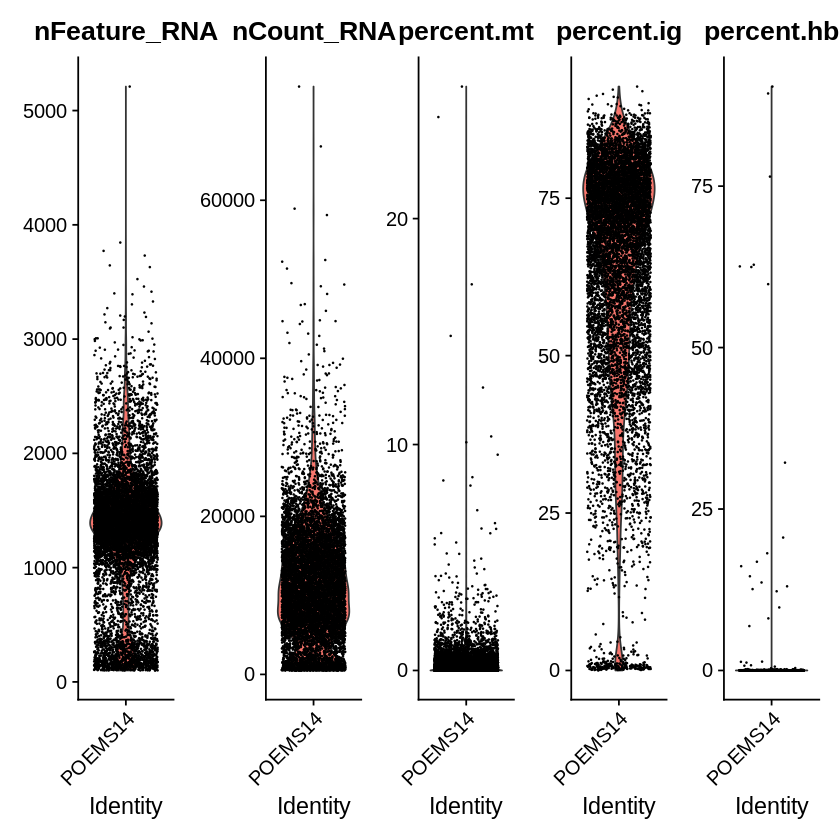

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [8]:
summary(normal@meta.data)

   orig.ident     nCount_RNA     nFeature_RNA    percent.mt      
 POEMS14:9394   Min.   :  498   Min.   : 100   Min.   : 0.00000  
                1st Qu.: 6310   1st Qu.:1145   1st Qu.: 0.03166  
                Median :10730   Median :1384   Median : 0.18927  
                Mean   :11255   Mean   :1316   Mean   : 0.32471  
                3rd Qu.:15608   3rd Qu.:1591   3rd Qu.: 0.38028  
                Max.   :74387   Max.   :5210   Max.   :25.84400  
   percent.ig      percent.hb      
 Min.   : 0.00   Min.   : 0.00000  
 1st Qu.:55.59   1st Qu.: 0.00000  
 Median :70.07   Median : 0.00000  
 Mean   :64.27   Mean   : 0.07794  
 3rd Qu.:77.26   3rd Qu.: 0.00000  
 Max.   :92.73   Max.   :90.41801  

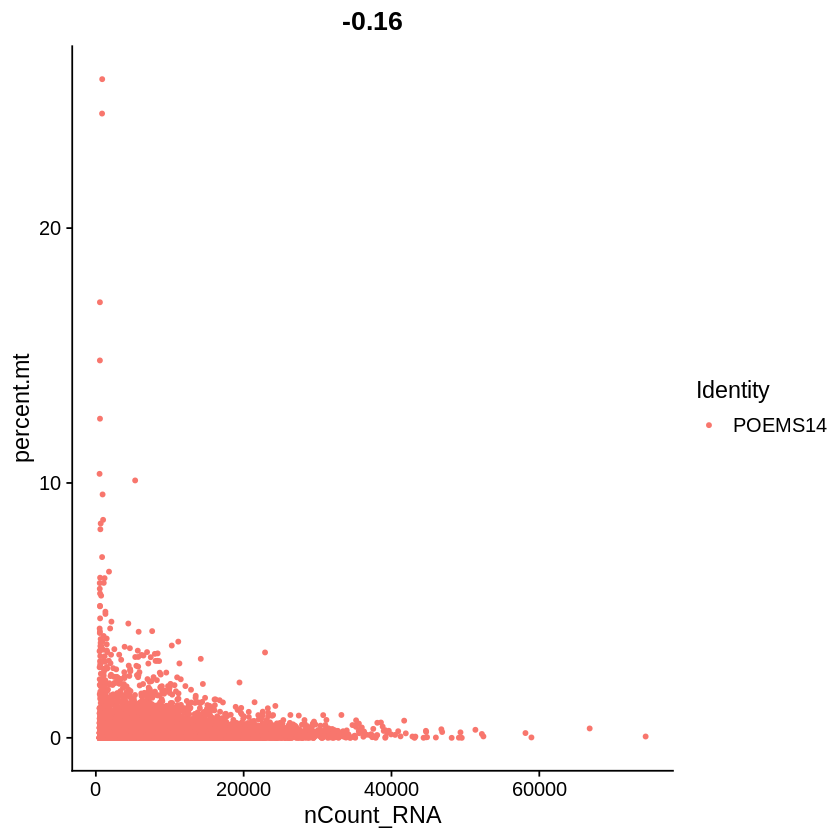

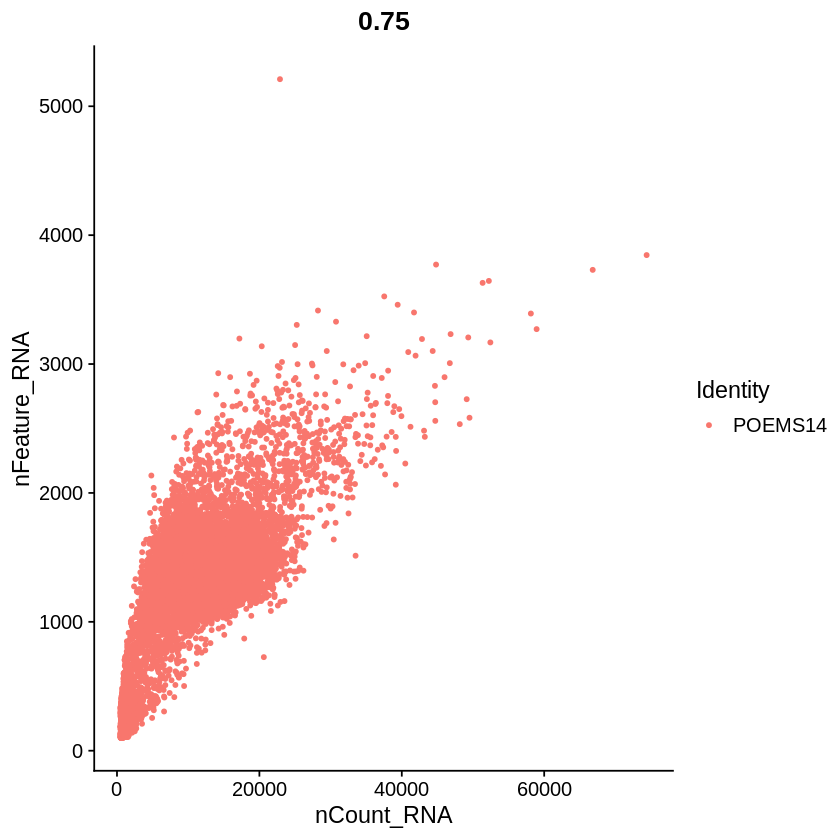

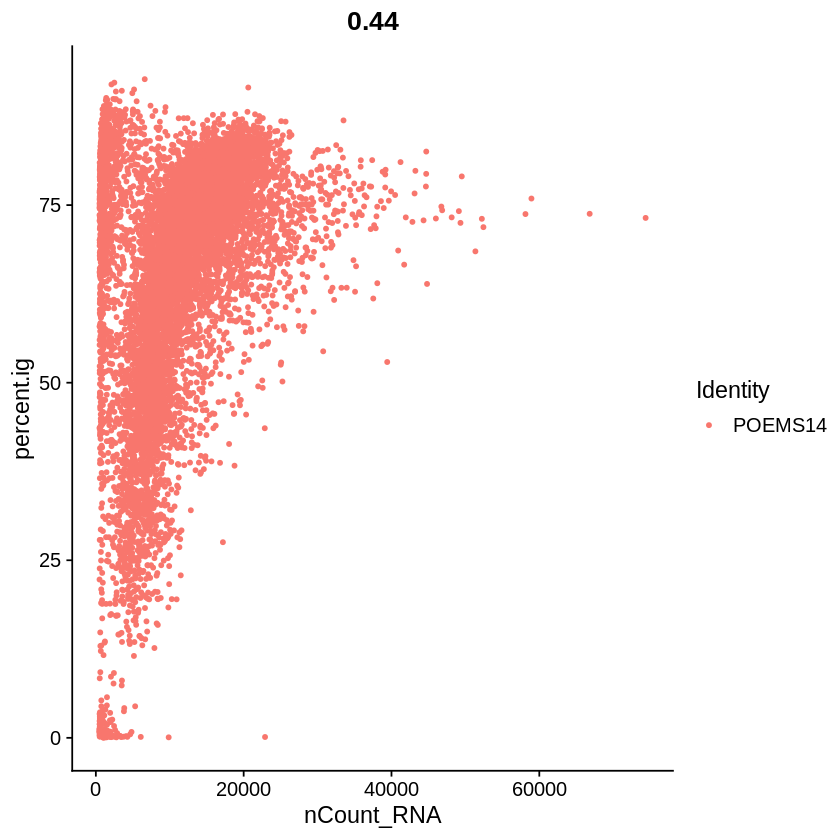

In [9]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [10]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 3000 & percent.mt < 5 & percent.hb<1)
normal

An object of class Seurat 
17194 features across 9316 samples within 1 assay 
Active assay: RNA (17194 features, 0 variable features)

In [11]:
all.genes <- rownames(normal)

In [12]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 17 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 17 rows containing missing values (geom_point).”


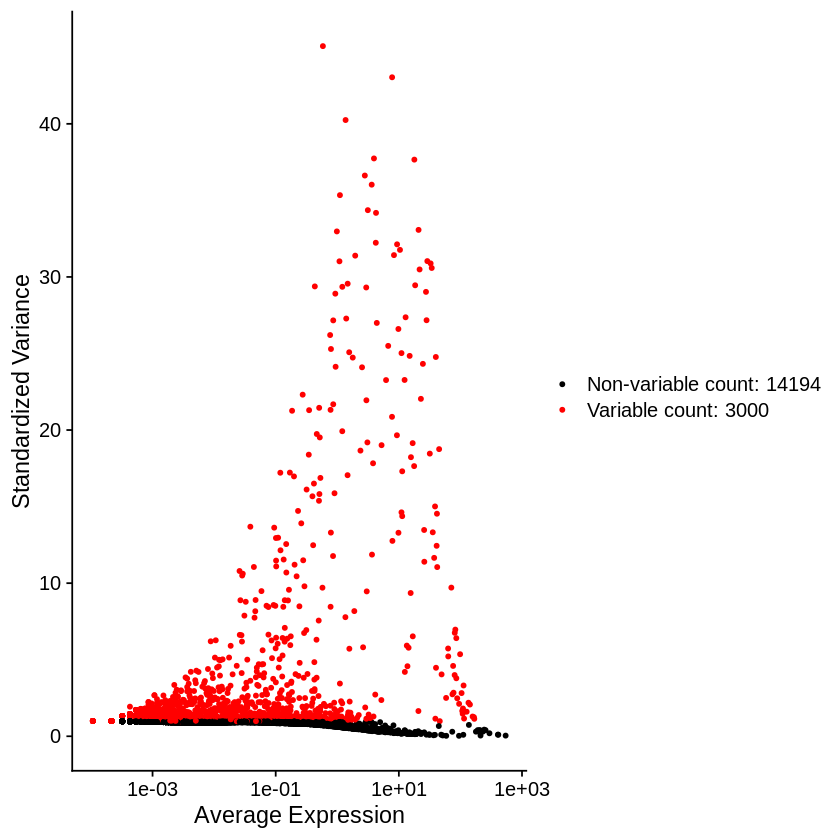

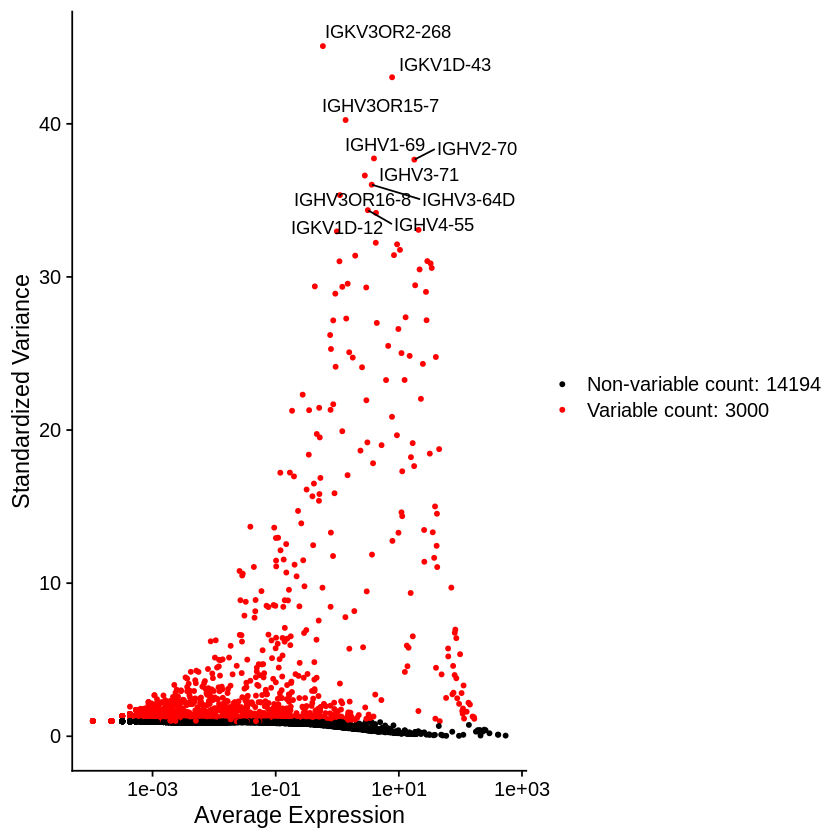

In [13]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10,repel = TRUE)
plot1
plot2

In [14]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [15]:
length(VariableFeatures(object = normal))

[1] 3000

In [16]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  IGHG4, CD79A, IGLV3-1, JCHAIN, IGHG3, VPREB3, DPEP1, IGHV3-48, IGKV3D-11, IGLC3 
	   IGHV3-21, IGHA2, IGLC2, QPCT, IGHV3-11, CD9, IGHV3-69-1, IGHV3-43, IGKV3D-20, AC233755.2 
	   HSPA5, AC078883.1, IGHV1-24, C12orf45, IGHV3-72, IGHV3-20, IGLV2-8, IGLV2-11, IGKV1-13, IGHV3OR16-13 
Negative:  C1QA, C1QB, APOE, C1QC, TYROBP, APOC1, SELENOP, FCER1G, HLA-DRA, HLA-DPB1 
	   MS4A6A, AIF1, HMOX1, HLA-DRB1, MS4A7, CD5L, CD68, CTSB, SLC40A1, GLUL 
	   VCAM1, LIPA, CCL18, CD163, SDC3, TMSB4X, LGMN, HLA-DPA1, TIMD4, CEBPD 
PC_ 2 
Positive:  APOC1, C1QA, C1QB, C1QC, AIF1, HMOX1, APOE, TYROBP, HLA-DPB1, MS4A6A 
	   FCER1G, CD5L, GLUL, CD68, HLA-DRA, MS4A7, CCL18, SELENOP, SLC40A1, SDC3 
	   LST1, VCAM1, TIMD4, FCGR3A, HLA-DRB1, FABP5, CD163, RAB32, CXCL12, DAB2 
Negative:  HSPA5, MT-ND5, CFLAR, NEAT1, RHOB, MT-ND4L, MT-CYB, PELI1, MDK, MT-CO1 
	   MT-ND2, FOSB, MT-ND6, ST6GAL1, TXNIP, MT-ND1, MT-ND3, NR4A1, MT-ATP6, NEB 
	   CITED2, MT-ND4, UBALD2, HLA-F, CERCAM, IER2, POU2F2, S100

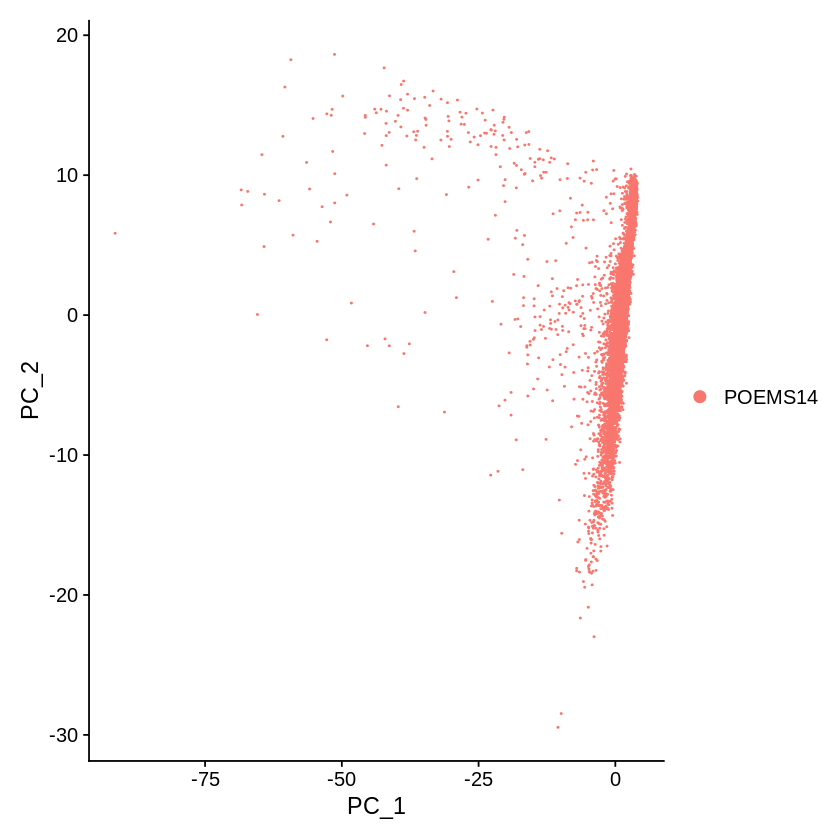

In [17]:
DimPlot(normal, reduction = "pca")

In [18]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42124 rows containing missing values (geom_point).”


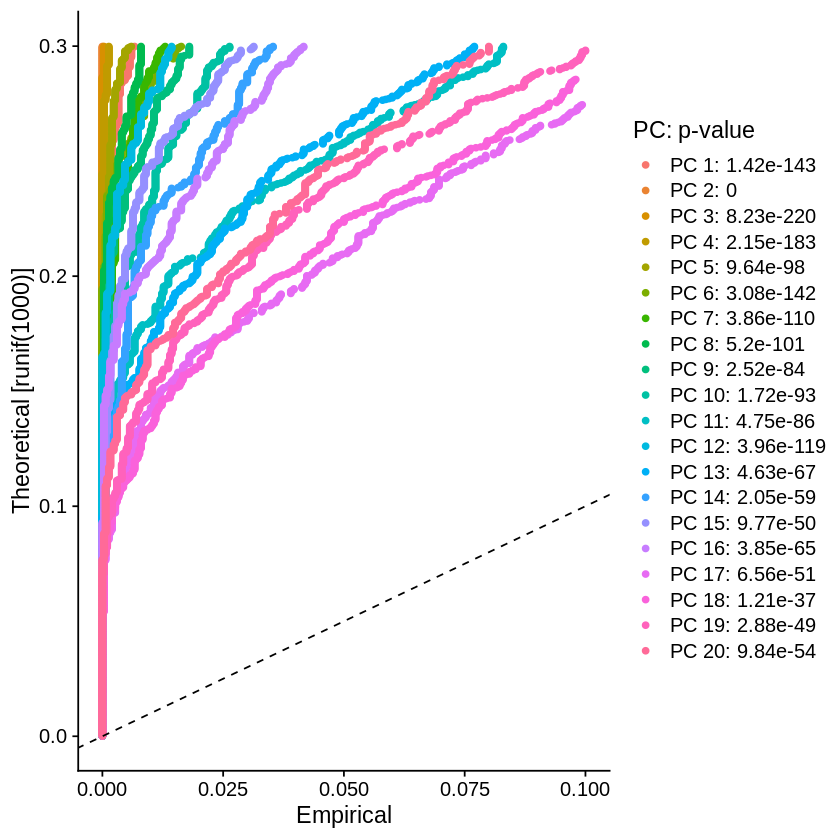

In [19]:
JackStrawPlot(normal, dims = 1:20)

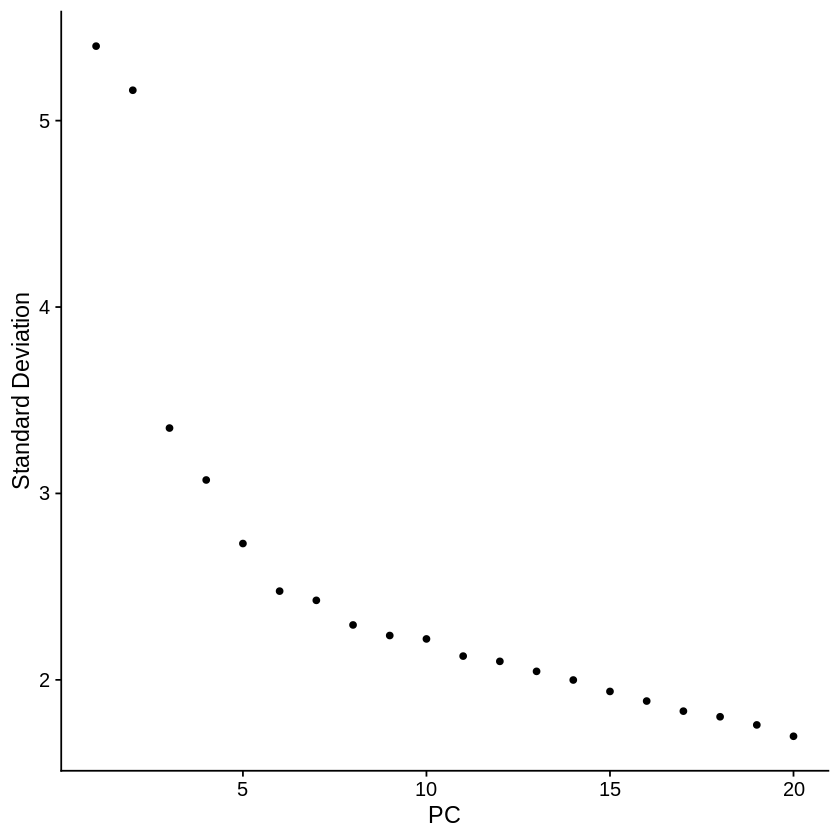

In [20]:
ElbowPlot(normal)

In [21]:
normal <- RunUMAP(normal, dims = 1:12)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:12:55 UMAP embedding parameters a = 0.9922 b = 1.112

10:12:55 Read 9316 rows and found 12 numeric columns

10:12:55 Using Annoy for neighbor search, n_neighbors = 30

10:12:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:12:56 Writing NN index file to temp file /tmp/RtmpeRNUPZ/file61eb826d17c97

10:12:56 Searching Annoy index using 1 thread, search_k = 3000

10:12:59 Annoy recall = 100%

10:12:59 Commencing smooth kNN distance calibration using 1 thread

10:12:59 Initializing fr

In [22]:
options(repr.plot.height=8,repr.plot.width=8)

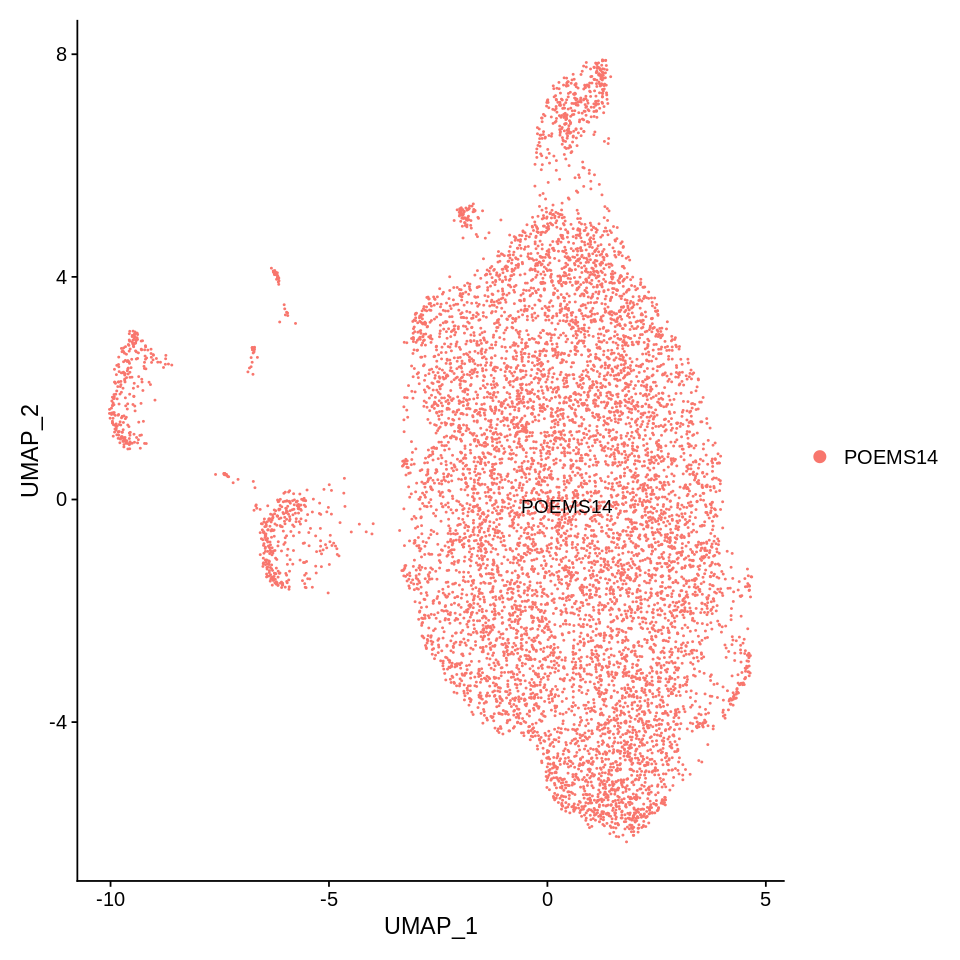

In [23]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


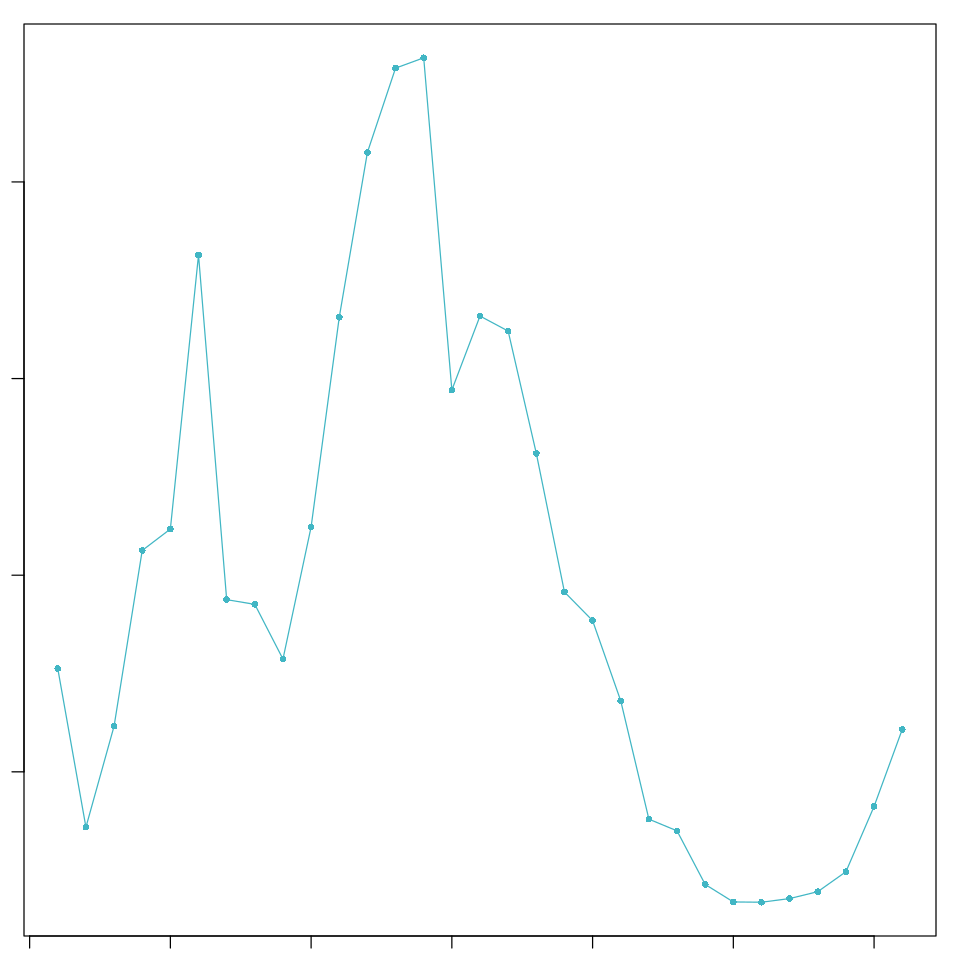

In [24]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:12, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [25]:
normal <- doubletFinder_v3(normal, PCs = 1:12, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 3105 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [26]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

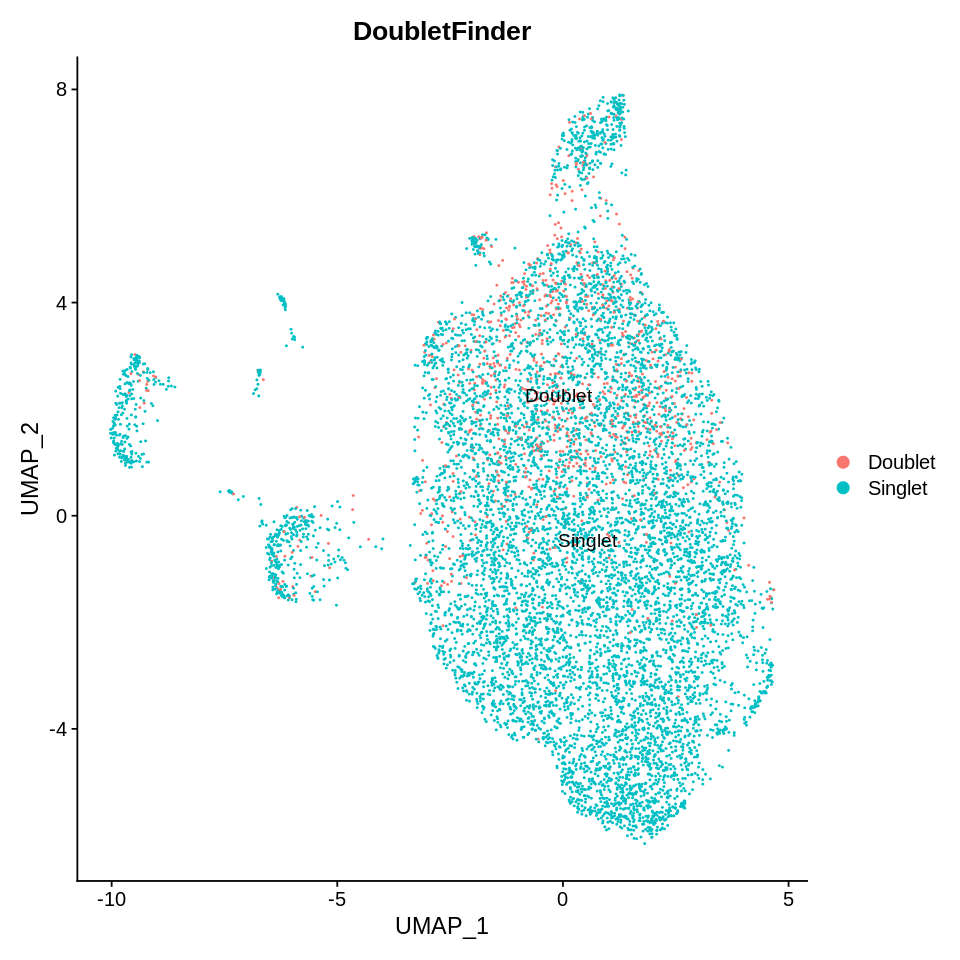

In [27]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [28]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [29]:
normal
normal2

An object of class Seurat 
17194 features across 9316 samples within 1 assay 
Active assay: RNA (17194 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
17194 features across 8384 samples within 1 assay 
Active assay: RNA (17194 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 20 rows containing missing values (geom_point).”


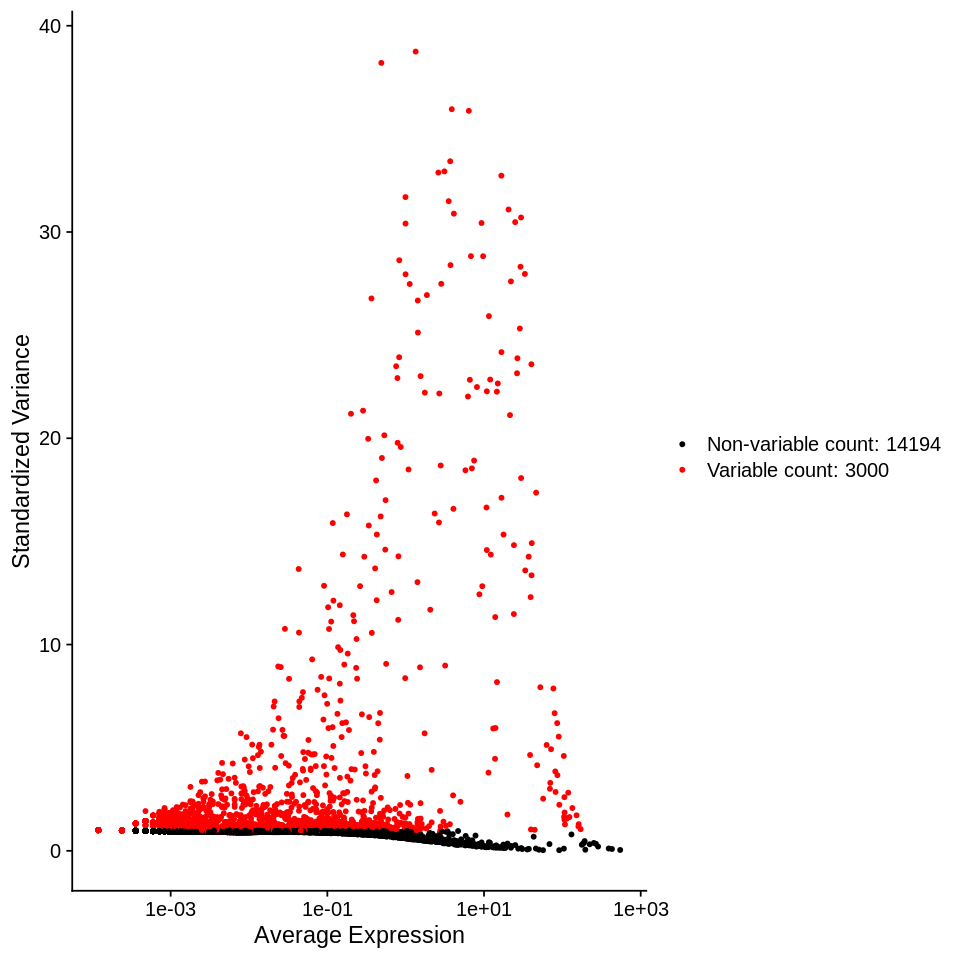

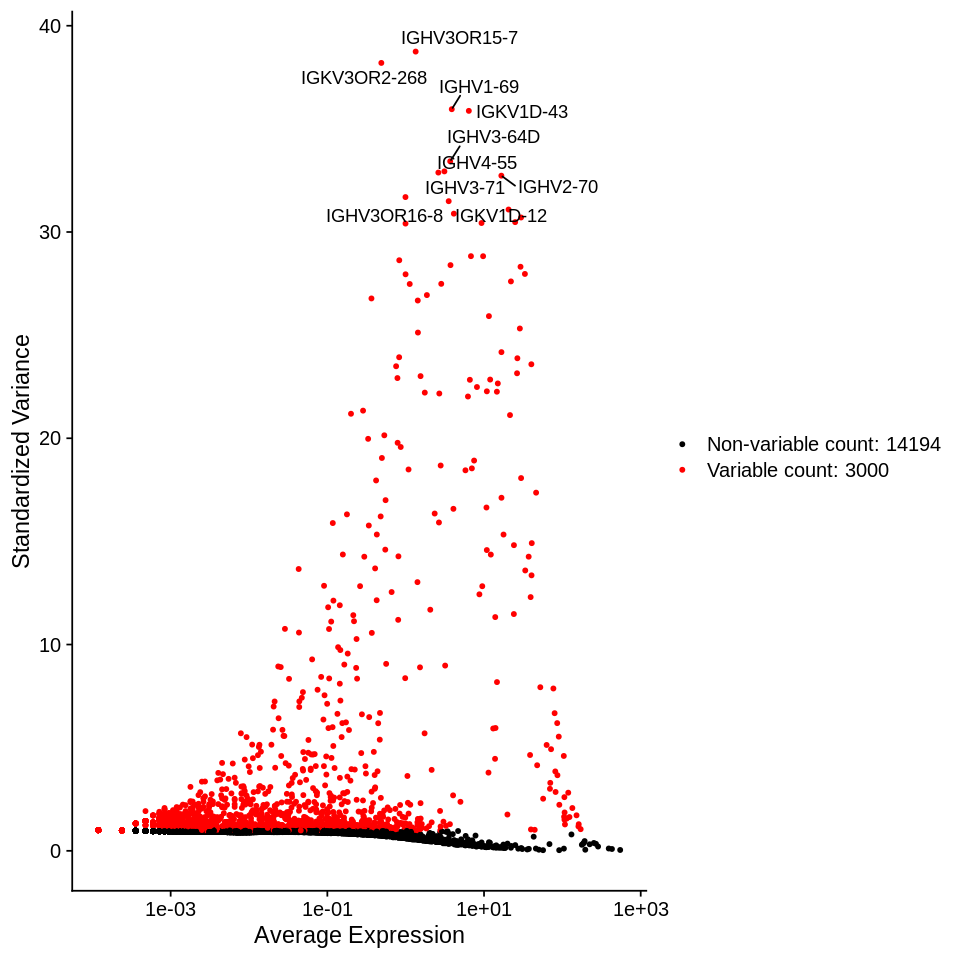

In [30]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [31]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [32]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  C1QA, C1QB, APOE, C1QC, TYROBP, APOC1, SELENOP, FCER1G, HLA-DRA, MS4A6A 
	   HLA-DPB1, AIF1, HMOX1, CD5L, HLA-DRB1, MS4A7, CD68, CTSB, SLC40A1, GLUL 
	   VCAM1, LIPA, CCL18, CD163, SDC3, TIMD4, LGMN, TMSB4X, CEBPD, HLA-DPA1 
Negative:  IGHG4, CD79A, IGHG3, IGLV3-1, DPEP1, JCHAIN, VPREB3, HSPA5, QPCT, CD9 
	   IGHV3-48, IGLC3, IGHA2, IGKV3D-11, IGLC2, C12orf45, IGHV3-21, CTHRC1, DUSP5, IGHV3-43 
	   AC233755.2, IGHV3-69-1, IGHV3-11, CITED2, IGLC1, AC012236.1, IGKV3D-20, IGHV3-20, IGHV3-72, TMEM156 
PC_ 2 
Positive:  APOC1, AIF1, C1QA, C1QB, C1QC, HMOX1, APOE, TYROBP, MS4A6A, HLA-DPB1 
	   FCER1G, CD5L, GLUL, CD68, MS4A7, HLA-DRA, CCL18, JCHAIN, LST1, SDC3 
	   SLC40A1, SELENOP, FABP5, RAB32, FCGR3A, TIMD4, VCAM1, CXCL12, IGSF6, CD163 
Negative:  HSPA5, NEAT1, RHOB, CFLAR, MT-ND5, PELI1, MT-ND4L, MT-CYB, MDK, MT-CO1 
	   MT-ND2, FOSB, ST6GAL1, ZFP36, TXNIP, MT-ND6, MT-ND1, NEB, MT-ND3, NR4A1 
	   MT-ATP6, MT-ND4, CERCAM, IER2, HLA-F, DHRS9, POU2F2, UBALD2, CITED2, S100A

In [33]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42250 rows containing missing values (geom_point).”


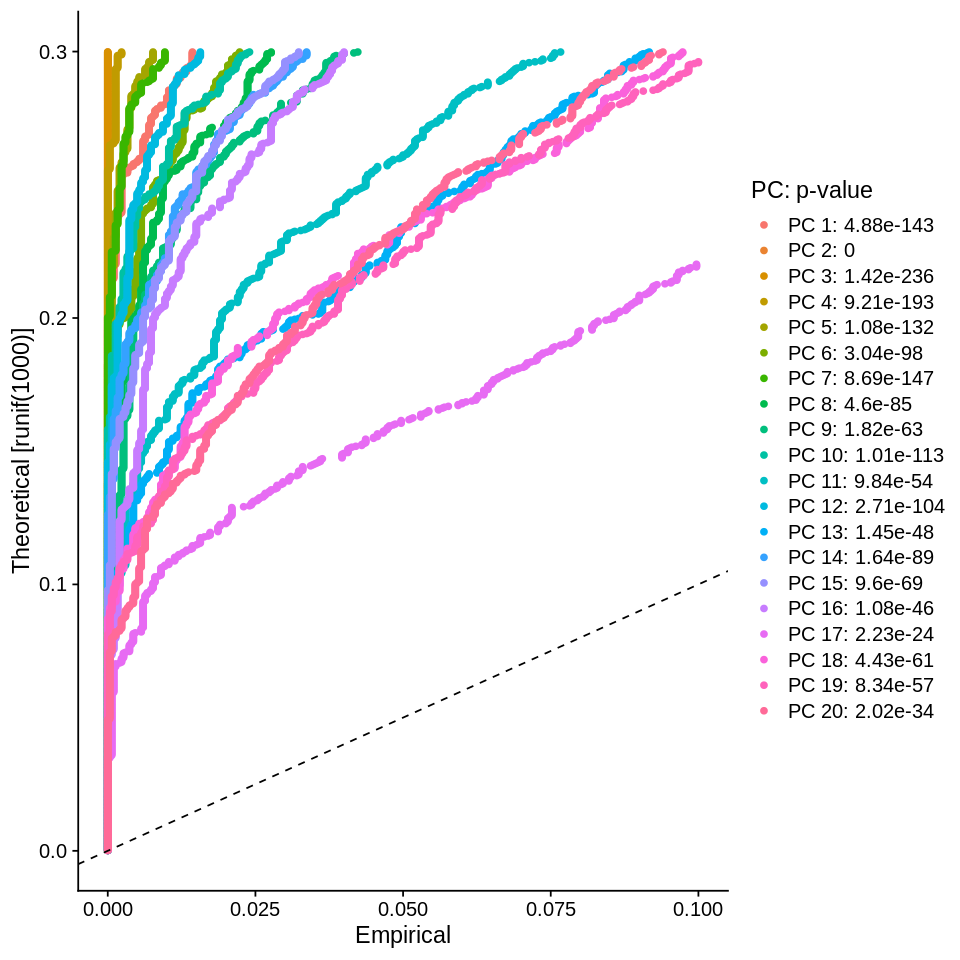

In [34]:
JackStrawPlot(normal2, dims = 1:20)

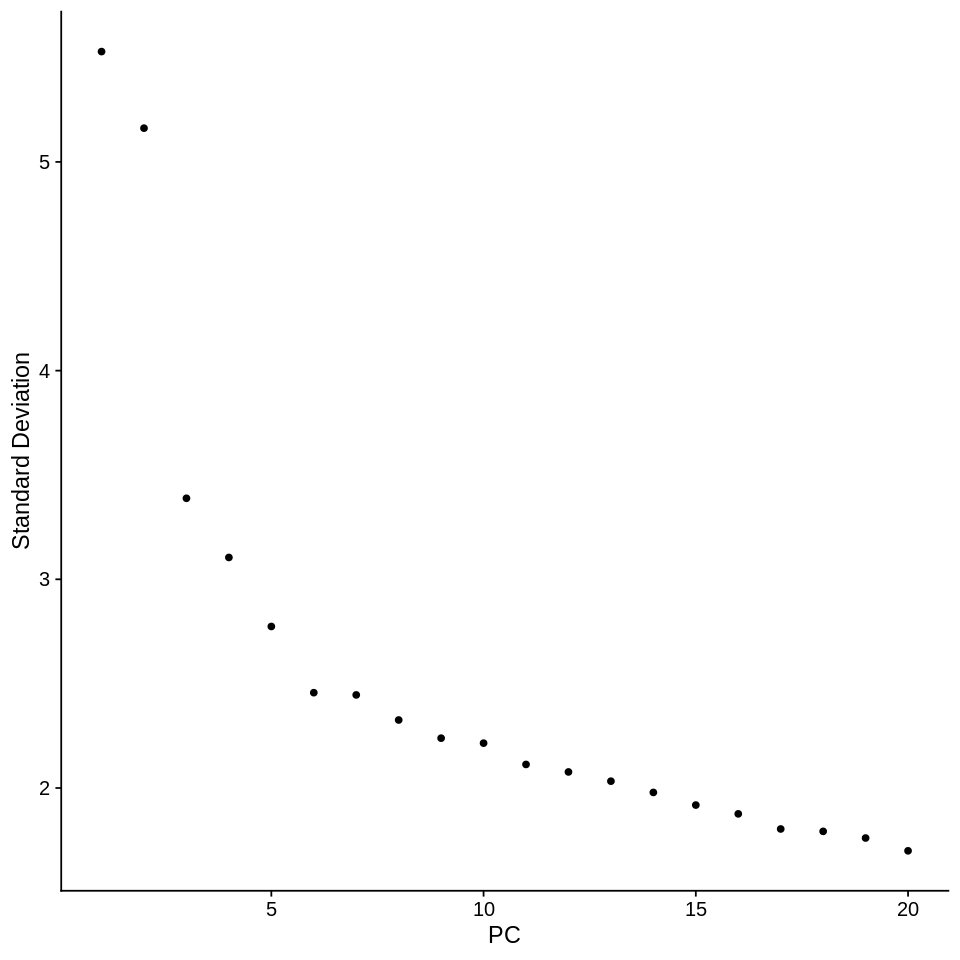

In [35]:
ElbowPlot(normal2)

In [36]:
normal2 <- FindNeighbors(normal2, dims = 1:12)
normal2 <- FindClusters(normal2, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8384
Number of edges: 254525

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8072
Number of communities: 12
Elapsed time: 0 seconds


In [37]:
normal2 <- RunUMAP(normal2, dims = 1:12)

10:20:12 UMAP embedding parameters a = 0.9922 b = 1.112

10:20:12 Read 8384 rows and found 12 numeric columns

10:20:12 Using Annoy for neighbor search, n_neighbors = 30

10:20:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:20:12 Writing NN index file to temp file /tmp/RtmpeRNUPZ/file61eb83ca3acae

10:20:12 Searching Annoy index using 1 thread, search_k = 3000

10:20:14 Annoy recall = 100%

10:20:15 Commencing smooth kNN distance calibration using 1 thread

10:20:15 Initializing from normalized Laplacian + noise

10:20:16 Commencing optimization for 500 epochs, with 338064 positive edges

10:20:23 Optimization finished



In [38]:
options(repr.plot.height=8,repr.plot.width=8)

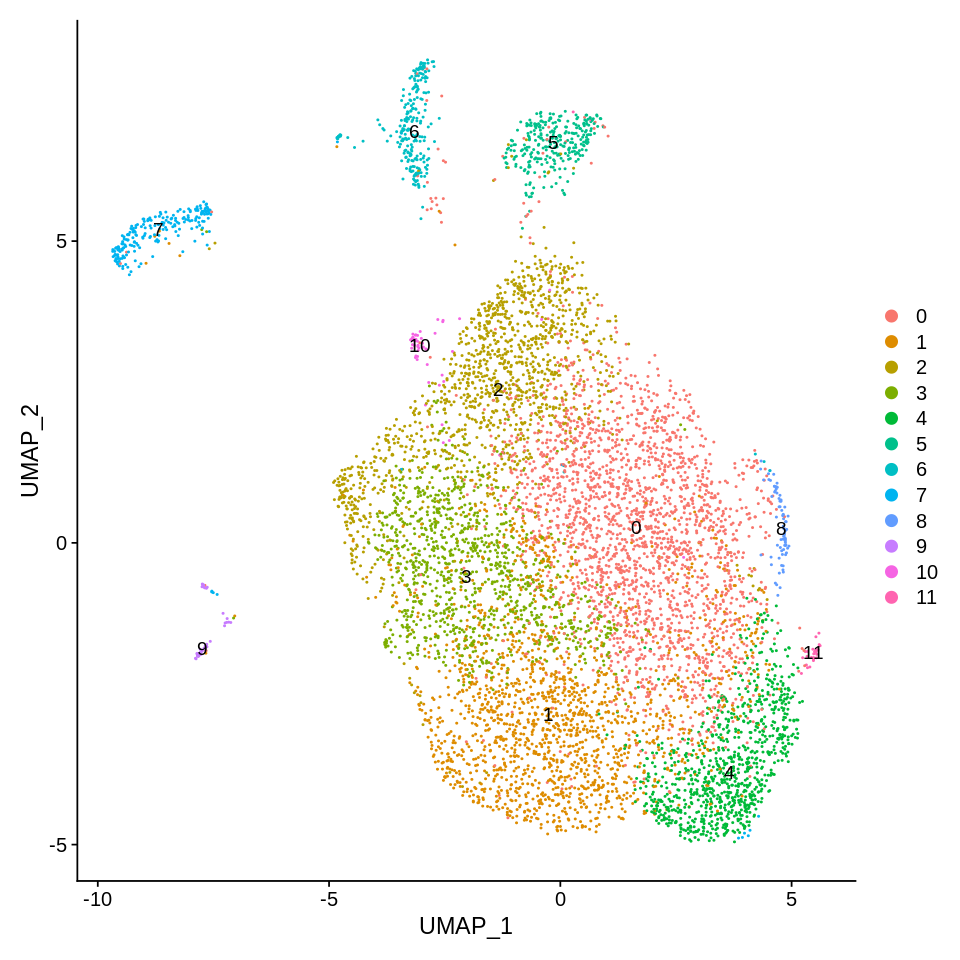

In [39]:
DimPlot(normal2, reduction = "umap",label=T)

In [40]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



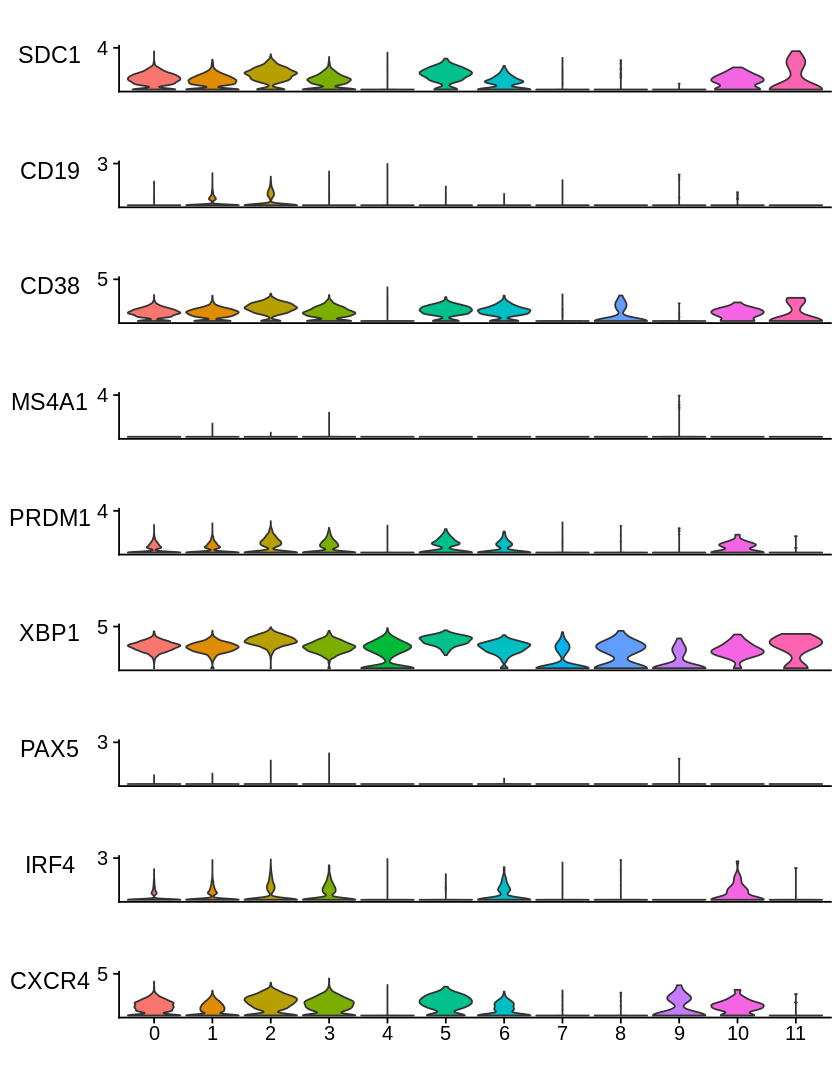

In [41]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



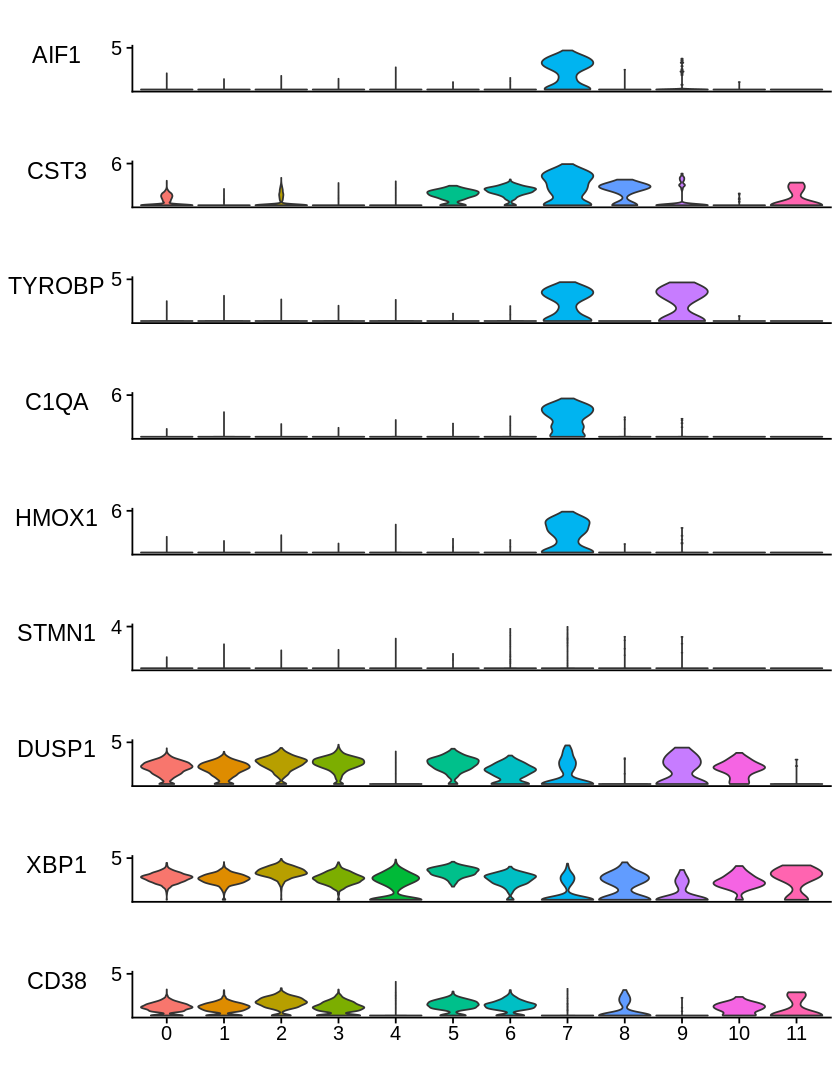

In [42]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [43]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



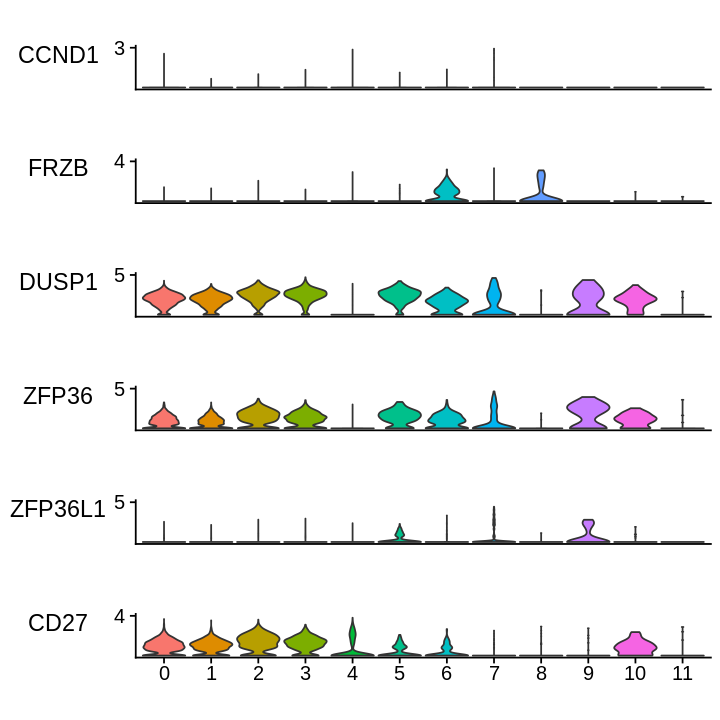

In [44]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [45]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




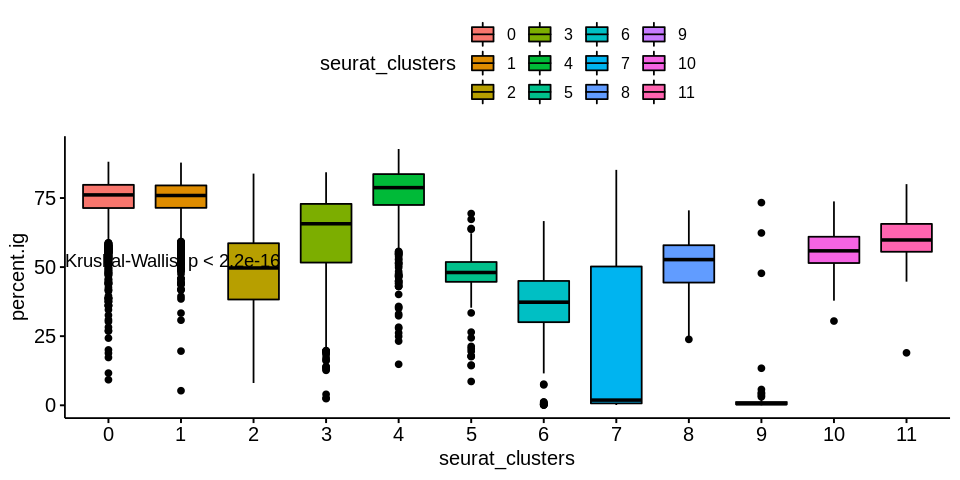

In [46]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [47]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene        
1   3.019523e-29 1.2406358  0.301 0.187  5.191768e-25 0       IGKV3D-11   
2   4.798660e-16 1.1088693  0.316 0.388  8.250816e-12 0       IGKV1-6     
3   8.257503e-08 1.0195316  0.627 0.554  1.419795e-03 0       IGKV3-20    
4   4.136536e-05 0.8037361  0.362 0.298  7.112359e-01 0       IGLV3-21    
5   2.443959e-04 0.8998797  0.644 0.585  1.000000e+00 0       IGKV4-1     
6   3.875898e-24 2.0122366  0.253 0.146  6.664219e-20 1       IGLV3-25    
7   2.413246e-23 1.1767200  0.469 0.330  4.149335e-19 1       IGLV2-14    
8   3.376400e-23 1.0541433  0.427 0.287  5.805383e-19 1       IGLV3-21    
9   7.096059e-20 1.2200011  0.415 0.286  1.220096e-15 1       IGLV2-8     
10  1.656619e-05 2.0552685  0.451 0.379  2.848390e-01 1       IGLV6-57    
11 1.709567e-247 3.2159545  0.503 0.138 2.939430e-243 2       IGKV1-39    
12 4.834000e-221 3.2806710  0.516 0.162 8.311580e-217 2       IGKV1D-39   
13 1.395860e-163 2.5752595  0.414 0.125 2.400041e-159 2       IGKV1D-8    
14  4.372238e-88 2.3412465  0.274 0.089  7.517626e-84 2       IGKV1-12    
15  2.296540e-44 2.3558173  0.313 0.165  3.948671e-40 2       IGHV4-61    
16  0.000000e+00 3.2412748  0.852 0.270  0.000000e+00 3       JCHAIN      
17 1.511696e-139 3.8484855  0.378 0.110 2.599210e-135 3       IGHM        
18  7.663592e-51 1.9232694  0.522 0.308  1.317678e-46 3       IGHV3-15    
19  4.809956e-43 1.6085691  0.559 0.353  8.270239e-39 3       IGHV3-74    
20  1.577104e-27 1.5507569  0.263 0.138  2.711672e-23 3       IGHV3-13    
21  7.254119e-22 1.3849677  0.113 0.290  1.247273e-17 4       IGKV1-16    
22  3.752848e-18 0.7755524  0.167 0.358  6.452647e-14 4       IGHV3-11    
23  7.804709e-15 0.9805422  0.209 0.387  1.341942e-10 4       IGKV1-6     
24  1.543285e-07 0.7709314  0.234 0.381  2.653524e-03 4       IGLV1-40    
25  1.169730e-06 0.6387543  0.203 0.326  2.011234e-02 4       IGLV2-8     
26  0.000000e+00 4.3237302  0.972 0.055  0.000000e+00 5       IGKV1D-27   
27  0.000000e+00 3.1596046  0.982 0.036  0.000000e+00 5       IGKV1D-33   
28 8.835370e-283 3.9696079  0.993 0.236 1.519154e-278 5       IGKV1-27    
29 6.679297e-191 4.6243032  0.993 0.477 1.148438e-186 5       IGHV3-30    
30 7.383184e-136 2.4597506  0.958 0.535 1.269465e-131 5       RHOB        
31 1.749058e-151 3.7075702  0.939 0.349 3.007330e-147 6       IGLV1-44    
32 5.517228e-147 3.5371883  0.931 0.417 9.486322e-143 6       IGLC2       
33 2.835267e-122 2.1207058  0.988 0.860 4.874959e-118 6       HLA-A       
34 2.064505e-118 1.8946248  0.988 0.962 3.549709e-114 6       HLA-B       
35  3.874054e-70 2.0240604  0.951 0.847  6.661048e-66 6       HSPA5       
36  0.000000e+00 5.7626434  0.762 0.043  0.000000e+00 7       APOE        
37  0.000000e+00 5.4500572  0.762 0.020  0.000000e+00 7       C1QB        
38  0.000000e+00 5.4085446  0.723 0.027  0.000000e+00 7       HMOX1       
39  0.000000e+00 5.2076316  0.831 0.020  0.000000e+00 7       C1QA        
40 4.897904e-134 5.1684140  1.000 0.977 8.421457e-130 7       FTL         
41  4.963813e-66 2.4848534  1.000 0.307  8.534780e-62 8       IGLV1-47    
42  2.217947e-61 4.2098485  1.000 0.360  3.813537e-57 8       IGLV1-44    
43  1.785096e-53 2.9926583  1.000 0.427  3.069294e-49 8       IGLC2       
44  5.422760e-46 2.2932591  1.000 0.975  9.323894e-42 8       HLA-C       
45  4.568002e-44 2.2173933  1.000 0.962  7.854223e-40 8       HLA-B       
46  0.000000e+00 5.7458230  0.481 0.000  0.000000e+00 9       NKG7        
47  0.000000e+00 5.1834260  0.346 0.000  0.000000e+00 9       GNLY        
48  0.000000e+00 3.8498004  0.462 0.001  0.000000e+00 9       CST7        
49 4.221168e-102 4.5742037  0.365 0.012  7.257877e-98 9       CCL4        
50  2.673550e-94 3.8179713  0.596 0.038  4.596901e-90 9       TYROBP      
51  0.000000e+00 3.8354082  0.712 0.006  0.000000e+00 10      IGLV4-3     
52 1.361031e-295 5.2782566  0.712 0.015 2.340157e-291 10      IGKV3OR2-268
53  4.818300e-30 2.0381970  

In [48]:
options(repr.plot.height=10,repr.plot.width=10)

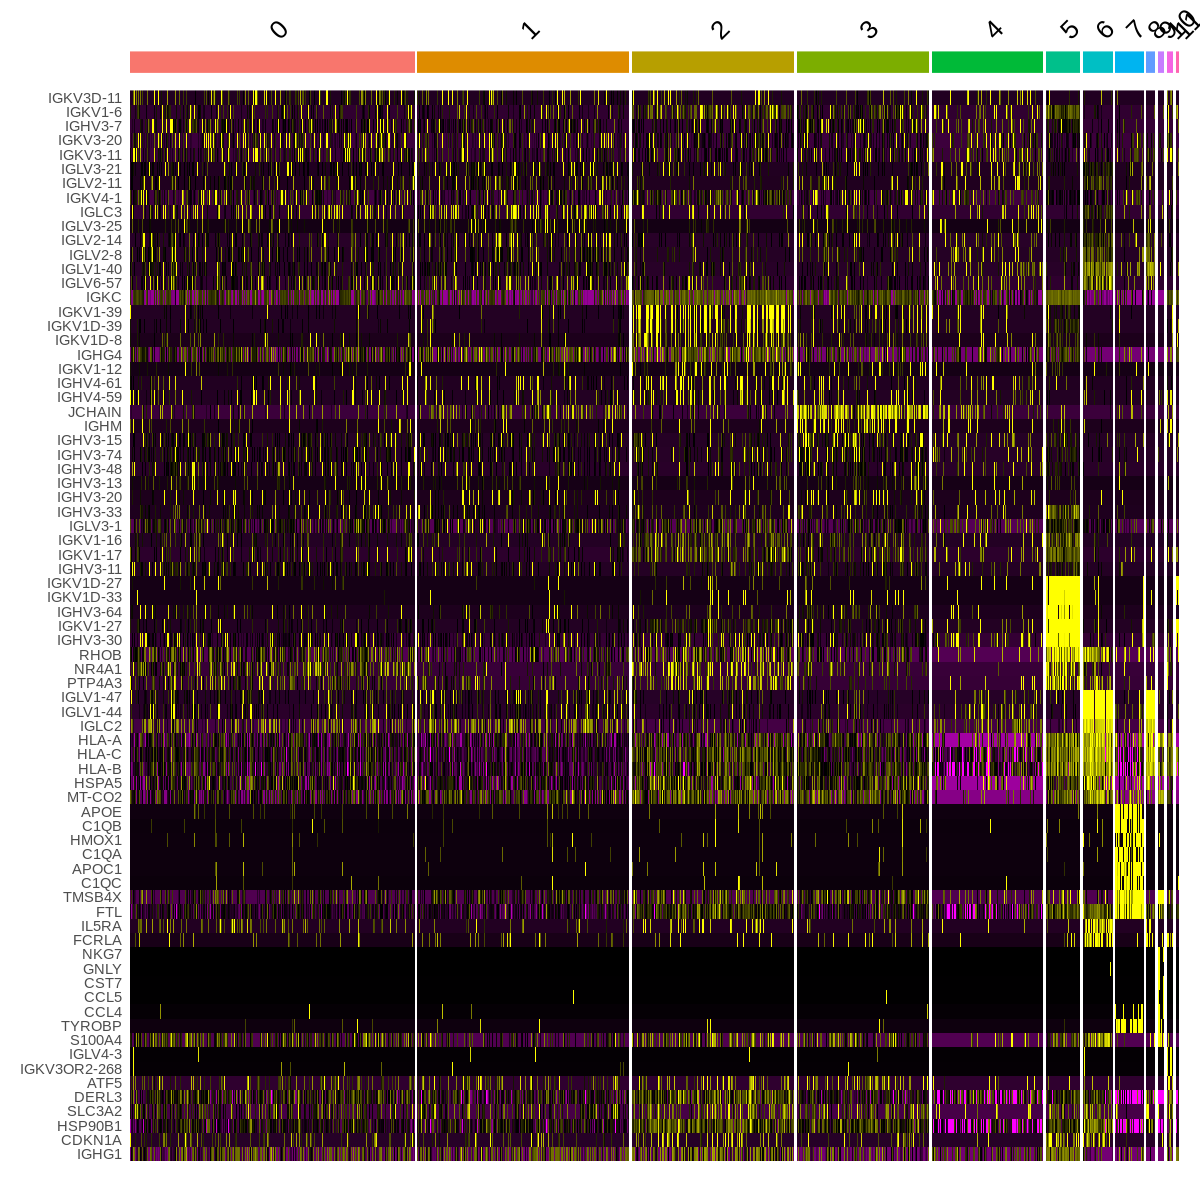

In [49]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [50]:
load('/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/HPCA.Rdata')
load('/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/NHD.RData')                       
library(Seurat)
library(SingleR)
library(viridis)
library(pheatmap)

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4


Attaching package: ‘stats4’


The following object is masked from ‘package:spam’:

    mle


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:spam’:

    cbind, rbind


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filte

In [51]:
normal2_for_SingleR <- GetAssayData(normal2, slot="data") 

In [52]:
clusterann<-SingleR(normal2_for_SingleR, nhd.se, method="cluster", clusters=normal2@meta.data$seurat_clusters,labels=nhd.se$label.main)
clusterann<-as.data.frame(row.names=clusterann@rownames,clusterann$labels)
clusterann

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

clusterann$labels
0  B cells          
1  B cells          
2  B cells          
3  B cells          
4  B cells          
5  B cells          
6  B cells          
7  Monocytes        
8  B cells          
9  Granulocytes     
10 B cells          
11 B cells

In [53]:
normal2.nhsc <- SingleR(test = normal2_for_SingleR, ref= nhd.se, labels = nhd.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

In [54]:
meta=normal2@meta.data
table(normal2.nhsc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-normal2.nhsc$labels

                 
                     0    1    2    3    4    5    6    7    8    9   10   11
  B cells         2284 1663 1304 1070  538  278  224   34   38    8   52   19
  Basophils         33   47   24   11   62    2    3    4    4    0    0    0
  CD4+ T cells       0    1    0    0    1    0    0    0    0    6    0    0
  CD8+ T cells       0    0    0    0    3    0    0    0    0    8    0    0
  CMPs               0    1    0    0   40    0    3    0    7    0    0    1
  Dendritic cells    7   17    1    3   77    2    2   30    8    0    0    0
  Eosinophils        8    7    0    3  139    2    1    8    5    0    0    4
  Erythroid cells    0    0    0    0    1    0    5    2    0    0    0    1
  Granulocytes       1    0    0    0   18    0    0    3    0    0    0    0
  HSCs               0    0    0    0    3    0    0    0    0    0    0    0
  Megakaryocytes     0    0    0    0    1    0    6    2    0    0    0    0
  Monocytes          7    5    2    0   29    

In [55]:
type<-as.data.frame(normal2.nhsc$labels)
count<-table(type)
count

type
        B cells       Basophils    CD4+ T cells    CD8+ T cells            CMPs 
           7512             190               8              11              52 
Dendritic cells     Eosinophils Erythroid cells    Granulocytes            HSCs 
            147             177               9              22               3 
 Megakaryocytes       Monocytes        NK cells      NK T cells 
              9             222              21               1 

In [59]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [60]:
options(repr.plot.height=8,repr.plot.width=8)

In [79]:
plasma<-subset(normal2,ident=c(0,1,2,3,5,6))

In [80]:
plasma

An object of class Seurat 
17194 features across 7030 samples within 1 assay 
Active assay: RNA (17194 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

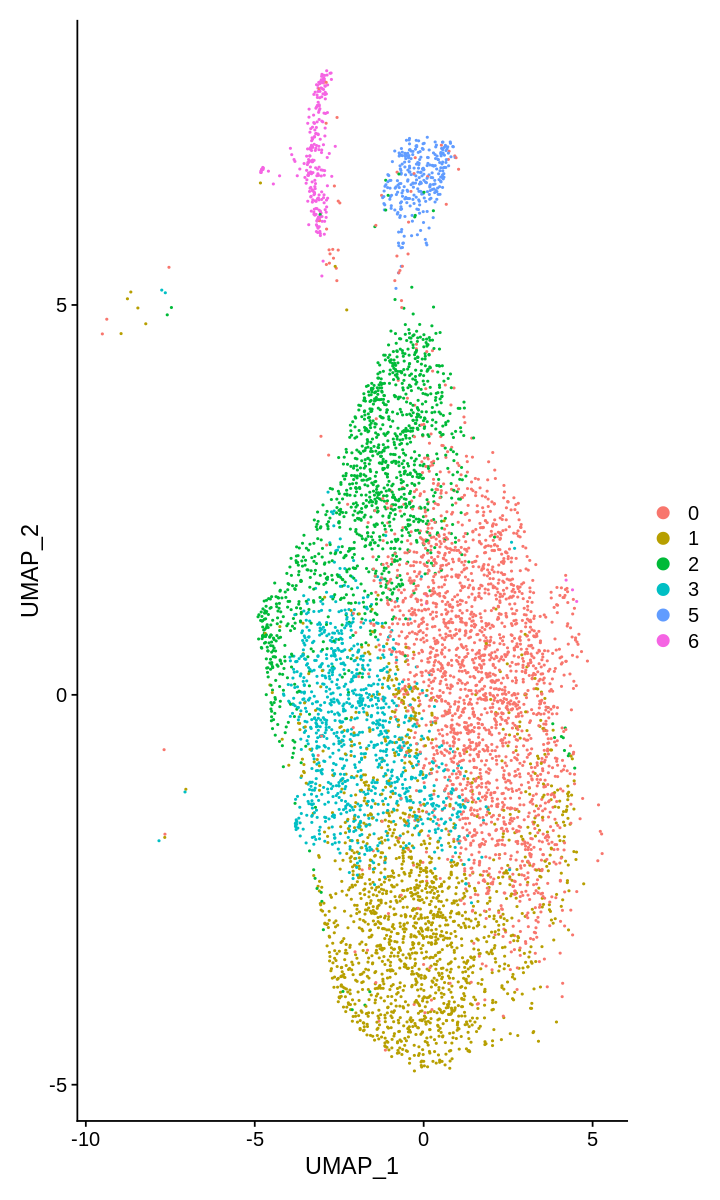

In [81]:
DimPlot(plasma, reduction = "umap")

In [82]:
plasma <- FindNeighbors(plasma, dims = 1:10)
plasma <- FindClusters(plasma, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7030
Number of edges: 215190

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7785
Number of communities: 9
Elapsed time: 0 seconds


In [83]:
plasma <- RunUMAP(plasma, dims = 1:10)

10:45:22 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

10:45:22 Read 7030 rows and found 10 numeric columns

10:45:22 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

10:45:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:45:23 Writing NN index file to temp file /tmp/RtmpeRNUPZ/file61eb8a496763

10:45:23 Searching Annoy index using 1 thread, search_k = 3000

10:45:25 Annoy recall = 100%

10:45:25 Commencing smooth kNN distance calibration using 1 thread

10:45:27 Initializing from normalized Laplacian + noise

10:45:27 Commencing opti

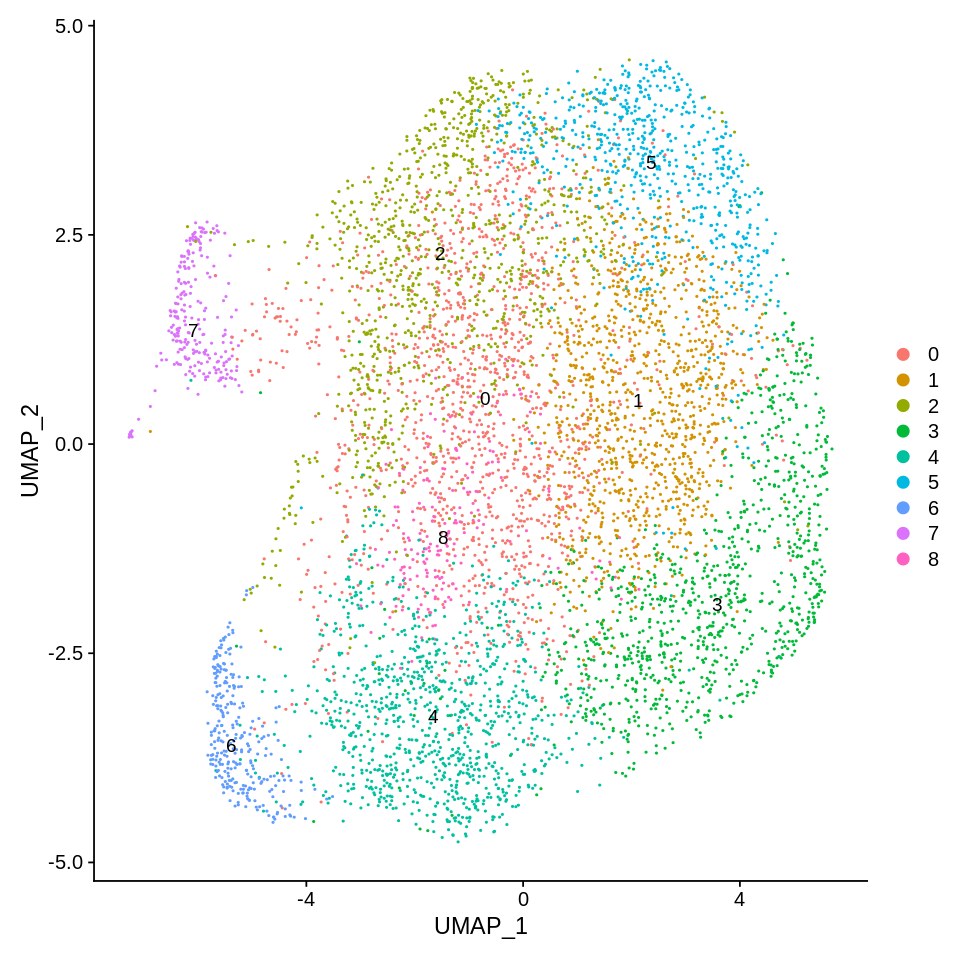

In [84]:
options(repr.plot.height=8,repr.plot.width=8)
DimPlot(plasma, reduction = "umap",label=T)

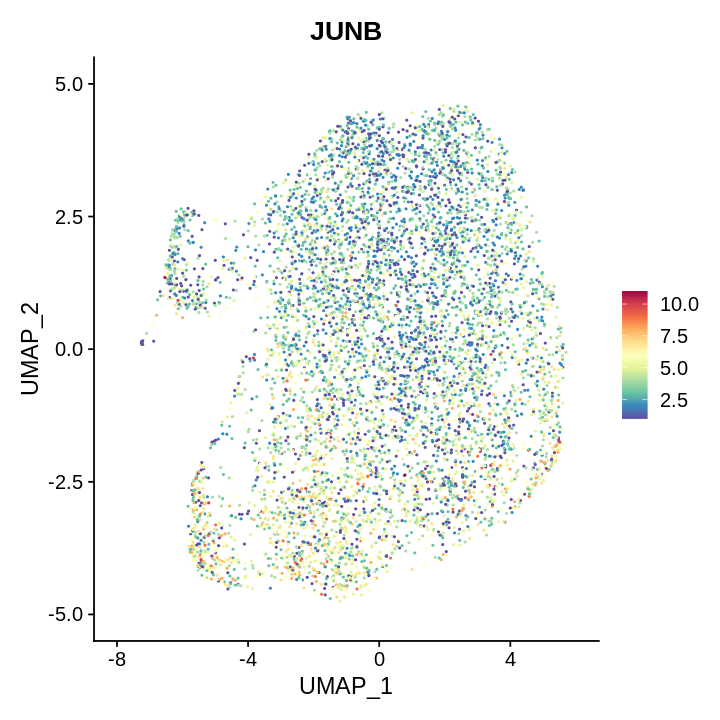

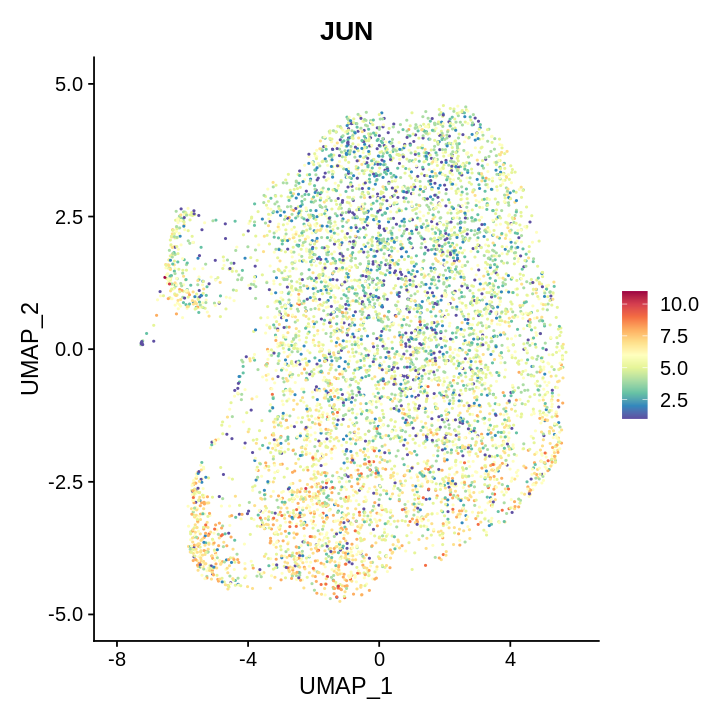

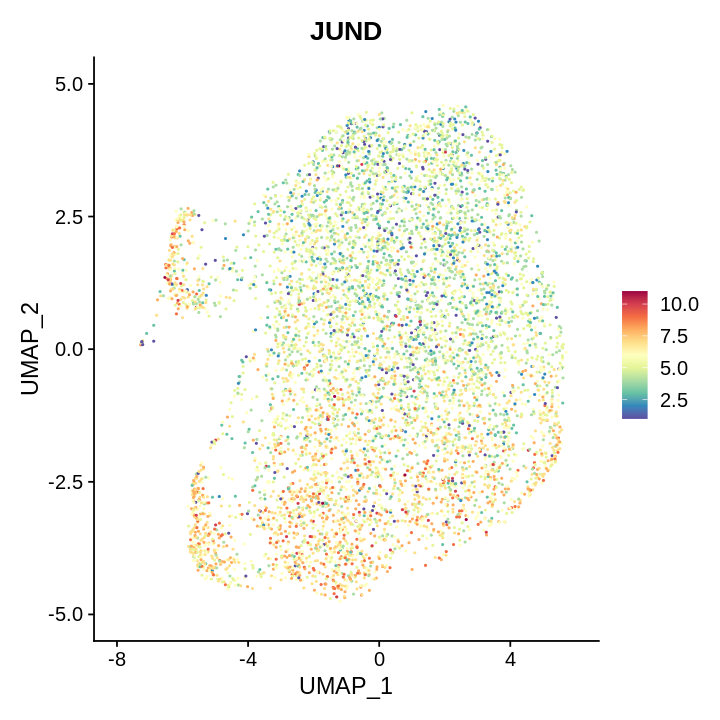

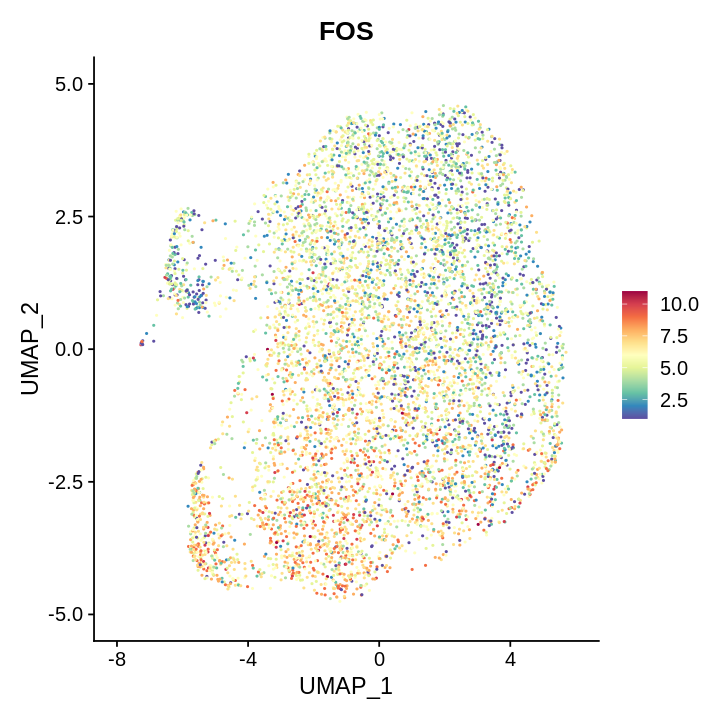

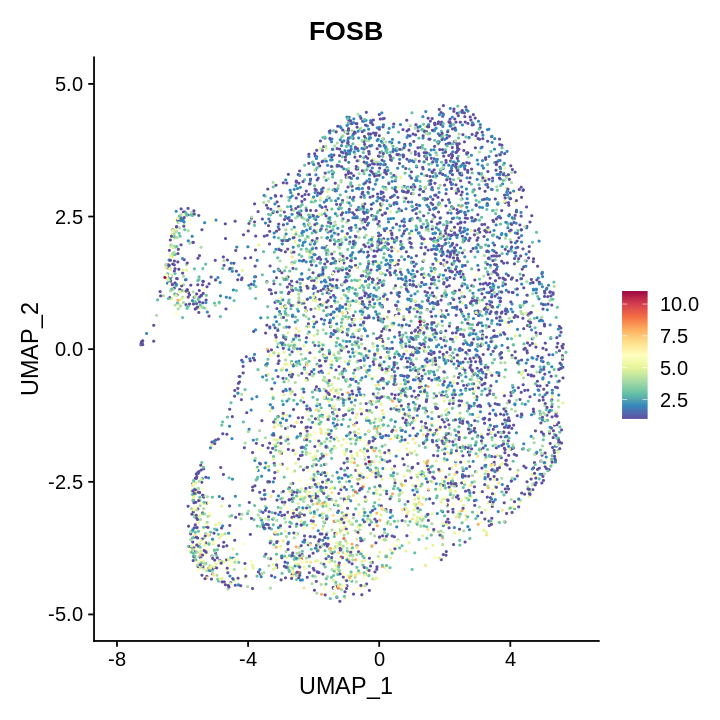

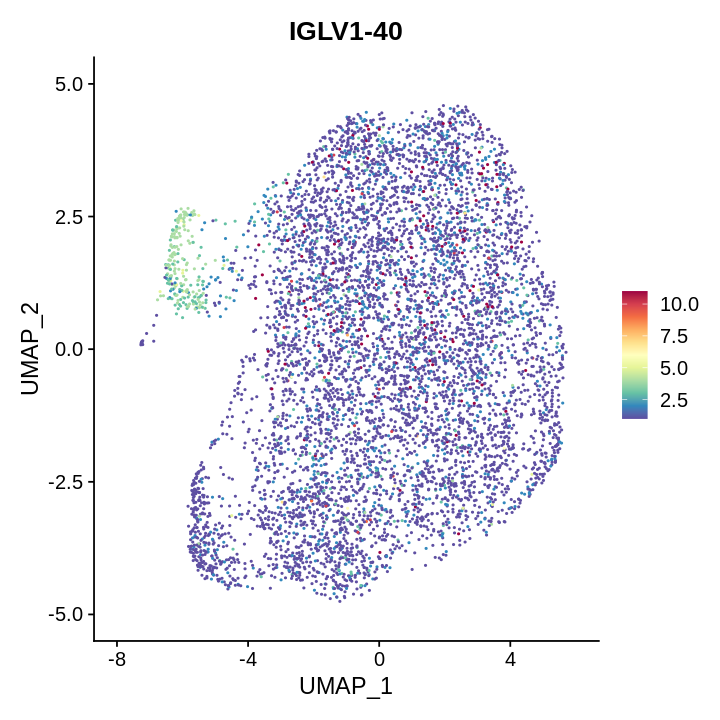

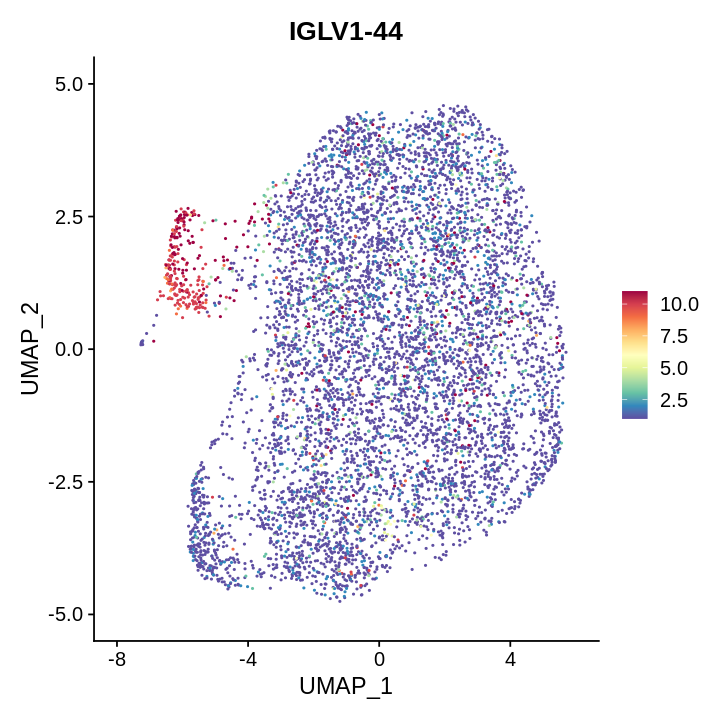

In [85]:
options(repr.plot.height=6,repr.plot.width=6)
FeaturePlot(plasma, features = c('JUNB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('JUN'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('JUND'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('FOS'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('FOSB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('IGLV1-40'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('IGLV1-44'),cols=rev(brewer.pal(11,'Spectral')))

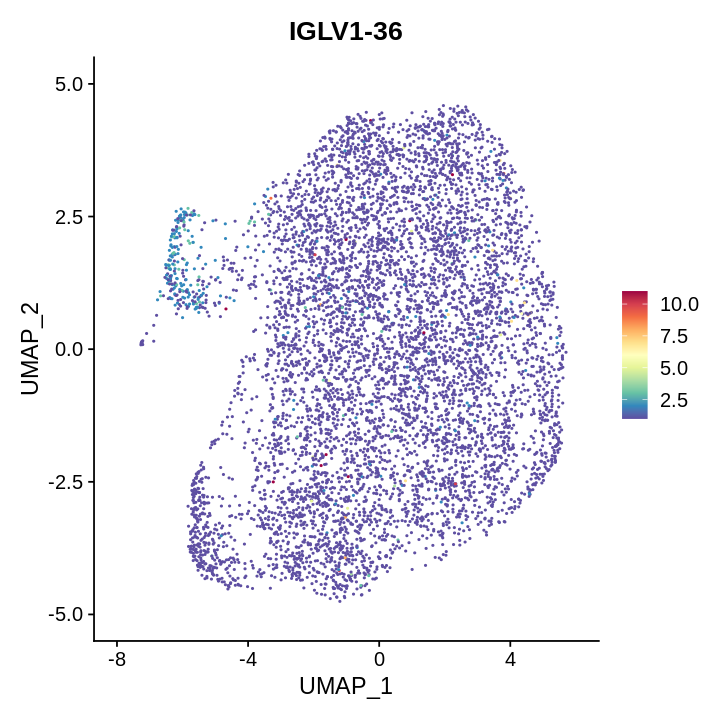

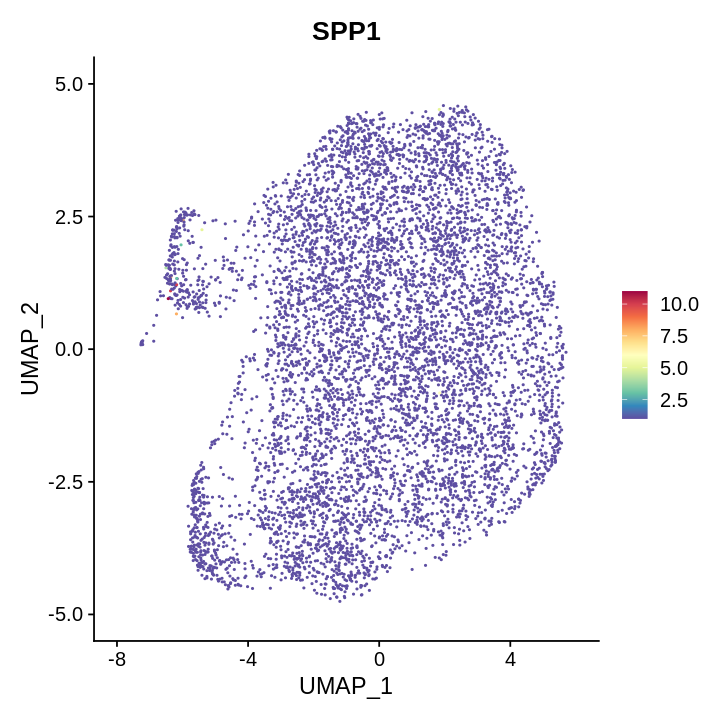

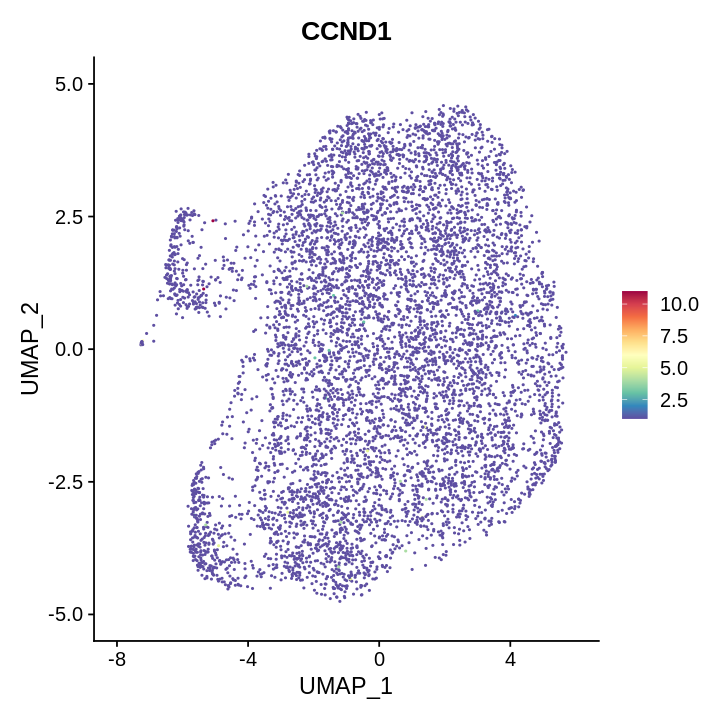

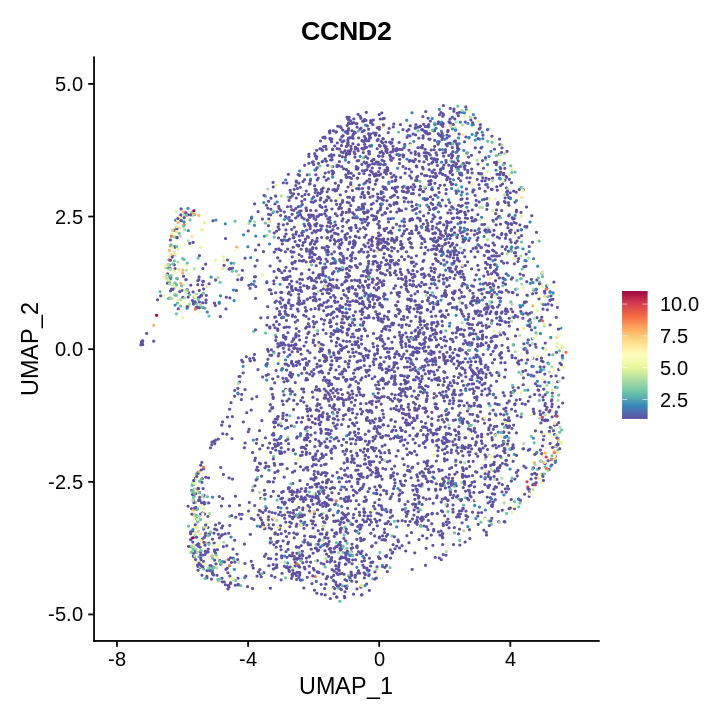

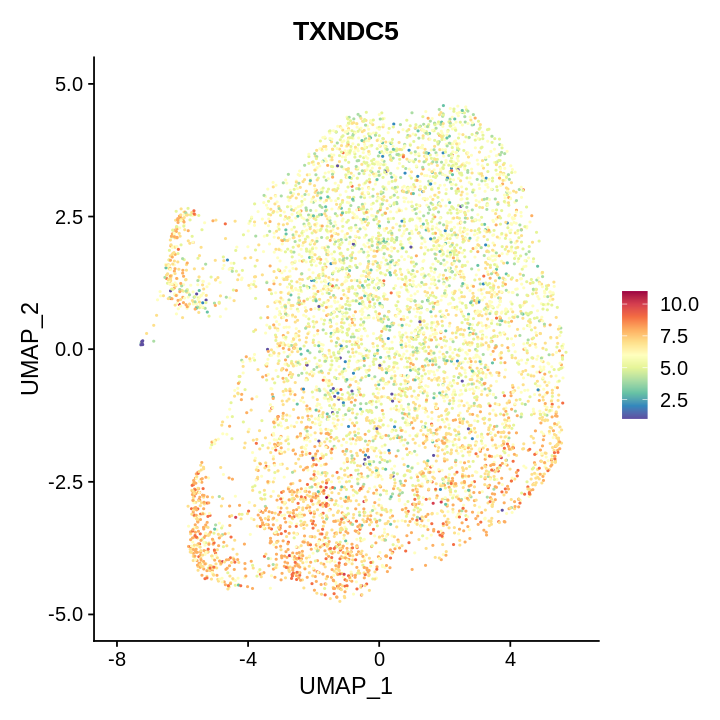

In [86]:
FeaturePlot(plasma, features = c('IGLV1-36'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('SPP1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('CCND1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('CCND2'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(plasma, features = c('TXNDC5'),cols=rev(brewer.pal(11,'Spectral')))

In [87]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene      
1   2.097437e-35 0.5209449  0.580 0.699  3.606333e-31 0       IGKV1-5   
2   6.050986e-15 0.7068068  0.421 0.314  1.040407e-10 0       IGLC3     
3   7.840717e-09 1.1822172  0.410 0.323  1.348133e-04 0       IGLV3-21  
4   2.559030e-08 1.1731972  0.291 0.222  4.399996e-04 0       IGKV3D-11 
5   3.911552e-05 1.1321604  0.318 0.258  6.725523e-01 0       IGLV2-11  
6   1.436991e-04 0.7244104  0.434 0.369  1.000000e+00 0       IGLV2-14  
7   1.770708e-04 0.5914991  0.377 0.319  1.000000e+00 0       IGLV2-8   
8   1.825898e-04 1.2423634  0.343 0.285  1.000000e+00 0       IGLV1-51  
9   3.171526e-04 0.5647111  0.436 0.371  1.000000e+00 0       IGLV1-40  
10  9.133677e-03 0.7935696  0.615 0.596  1.000000e+00 0       IGKV3-20  
11 3.236952e-298 2.3339216  0.790 0.277 5.565615e-294 1       JCHAIN    
12  4.000305e-66 2.5639458  0.315 0.126  6.878125e-62 1       IGHM      
13  4.545798e-27 0.8441930  0.178 0.327  7.816046e-23 1       IGKV1-16  
14  1.751193e-24 0.5524409  0.598 0.690  3.011001e-20 1       IGKV1-5   
15  1.299679e-12 1.0800092  0.479 0.355  2.234668e-08 1       IGHV3-15  
16  4.876056e-12 1.5692647  0.385 0.273  8.383891e-08 1       IGHV3-72  
17  1.113061e-09 0.6372249  0.670 0.546  1.913797e-05 1       IGHV3-23  
18  8.741848e-07 0.6745657  0.366 0.281  1.503073e-02 1       AC233755.2
19  1.148540e-04 0.8357962  0.612 0.644  1.000000e+00 1       IGKV4-1   
20  1.820733e-04 1.1406294  0.258 0.203  1.000000e+00 1       IGHV3-73  
21  6.553414e-21 0.3877080  0.296 0.425  1.126794e-16 2       IGKV1-9   
22  1.467088e-20 0.5139072  0.247 0.391  2.522511e-16 2       IGKV1-17  
23  8.028080e-19 0.5041442  0.291 0.420  1.380348e-14 2       IGKV1-6   
24  2.949673e-17 0.4917185  0.606 0.688  5.071668e-13 2       IGKV1-5   
25  4.505725e-05 0.4638074  0.285 0.227  7.747143e-01 2       IGKV3D-11 
26  3.829519e-04 0.6254566  0.393 0.320  1.000000e+00 2       IGLV2-8   
27  2.378000e-03 0.3948686  0.346 0.281  1.000000e+00 2       IGHV3-72  
28  4.270816e-03 0.3348454  0.312 0.262  1.000000e+00 2       IGLV2-11  
29  7.791969e-03 0.6121211  0.379 0.321  1.000000e+00 2       IGLV1-47  
30  9.721427e-03 0.4208836  0.383 0.333  1.000000e+00 2       IGLV3-21  
⋮  ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮         
61  0.000000e+00 4.331785   0.972 0.057  0.000000e+00 6       IGKV1D-27 
62  0.000000e+00 3.128460   0.986 0.040  0.000000e+00 6       IGKV1D-33 
63  0.000000e+00 1.570346   0.964 0.164  0.000000e+00 6       IGHV3-64  
64 3.627988e-260 3.982401   0.993 0.261 6.237962e-256 6       IGKV1-27  
65 1.901616e-183 4.804277   0.993 0.516 3.269638e-179 6       IGHV3-30  
66 1.689941e-124 2.392893   0.957 0.616 2.905685e-120 6       RHOB      
67 1.385566e-111 1.549914   0.911 0.503 2.382343e-107 6       MDK       
68  3.883308e-85 1.728313   0.804 0.374  6.676959e-81 6       NR4A1     
69  7.297362e-84 1.523598   0.979 0.763  1.254708e-79 6       IGHG1     
70  2.662015e-82 1.674186   0.786 0.352  4.577069e-78 6       PTP4A3    
71 3.618620e-172 1.942957   0.947 0.308 6.221856e-168 7       IGLV1-47  
72 1.848275e-153 4.121209   0.947 0.365 3.177924e-149 7       IGLV1-44  
73 9.801417e-147 3.654990   0.938 0.430 1.685256e-142 7       IGLC2     
74 2.472702e-136 2.047314   0.934 0.342 4.251564e-132 7       CST3      
75 2.700718e-126 2.232978   0.988 0.931 4.643615e-122 7       HLA-A     
76 5.647516e-122 1.887775   0.979 0.998 9.710340e-118 7       HLA-C     
77 6.016584e-121 1.962744   0.988 0.996 1.034491e-116 7       HLA-B     
78  1.165240e-67 2.022363   0.951 0.944  2.003514e-63 7       HSPA5     
79  5.670488e-58 1.827789   0.996 0.978  9.749838e-54 7       ACTB      
80  6.004868e-20 2.096508   0.251 0.598  1.032477e-15 7       TMSB4X    
81  5.239952e-29 2.148154   0.815 0.514  9.009574e-25 8       IGHV3-7   
82  1.652840e-21 2.279070   0.675 0.415  2.841894e-17 8       IGHV3-74  
83  6.343516e-17 1.388614   0.715 0.580  1.090704e-12 8      

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



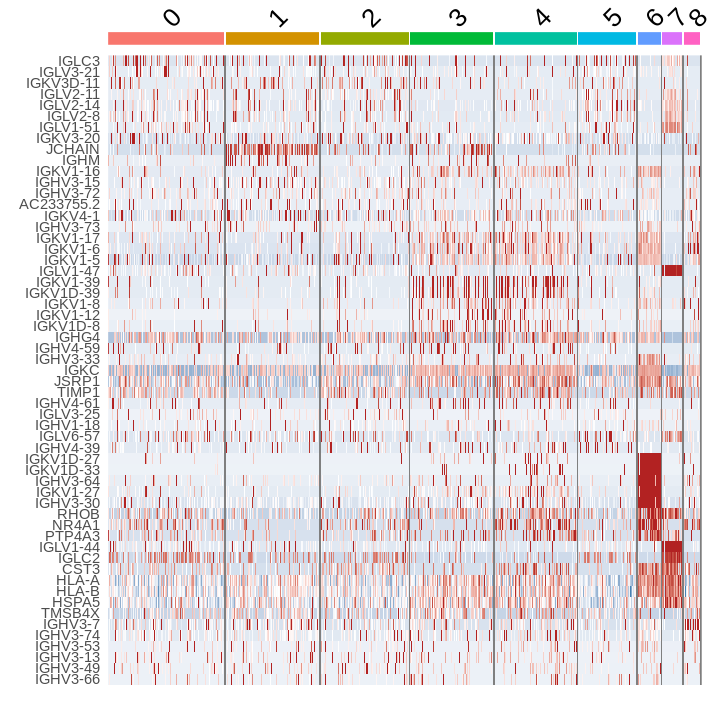

In [88]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [89]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



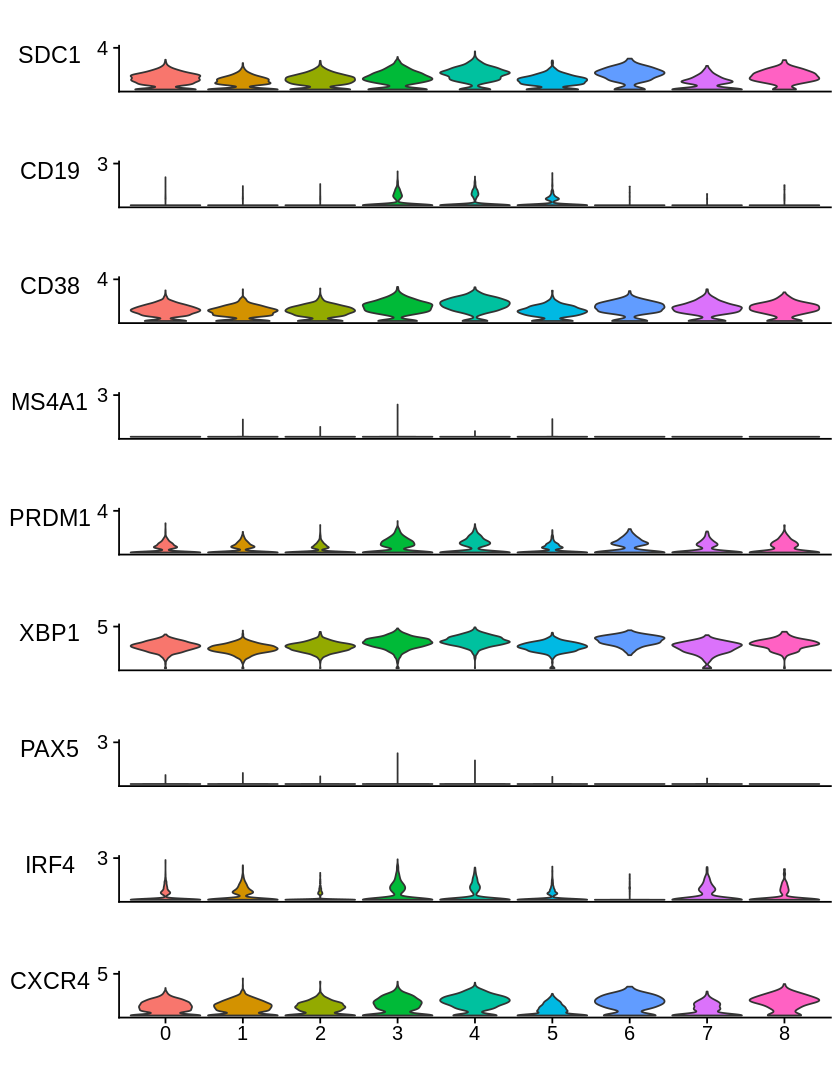

In [90]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



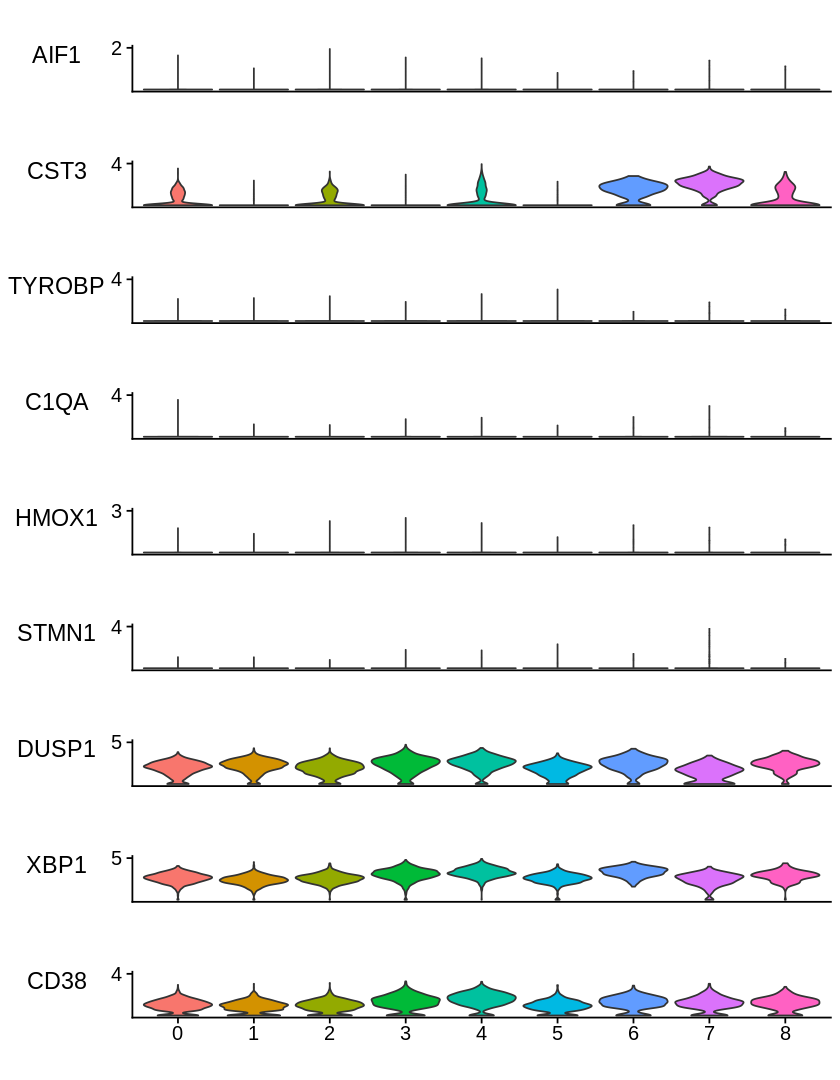

In [91]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [92]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



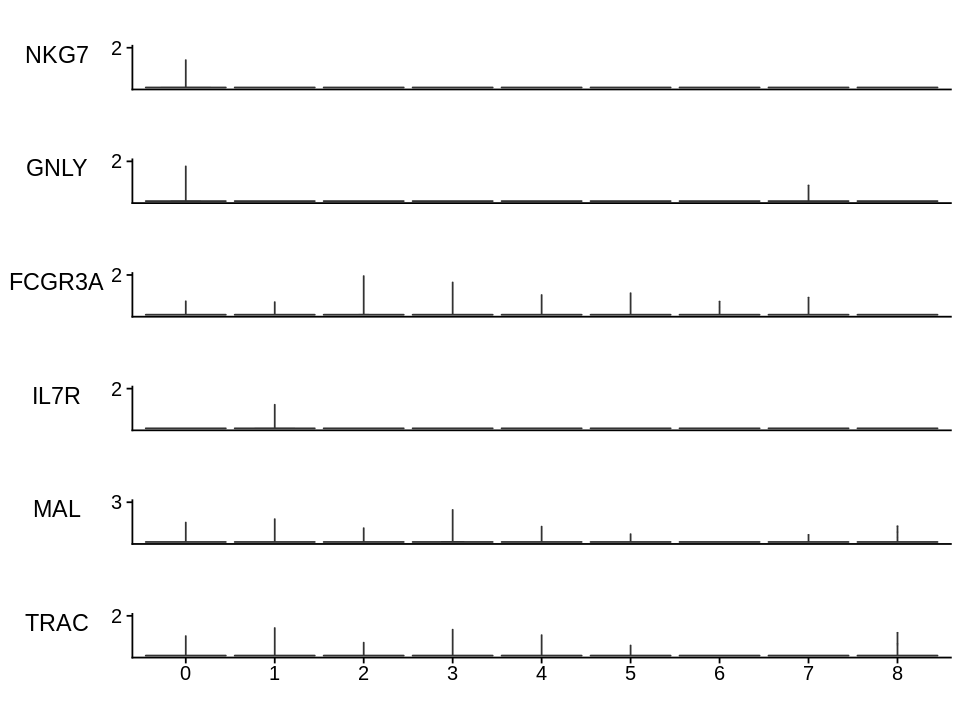

In [93]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', 

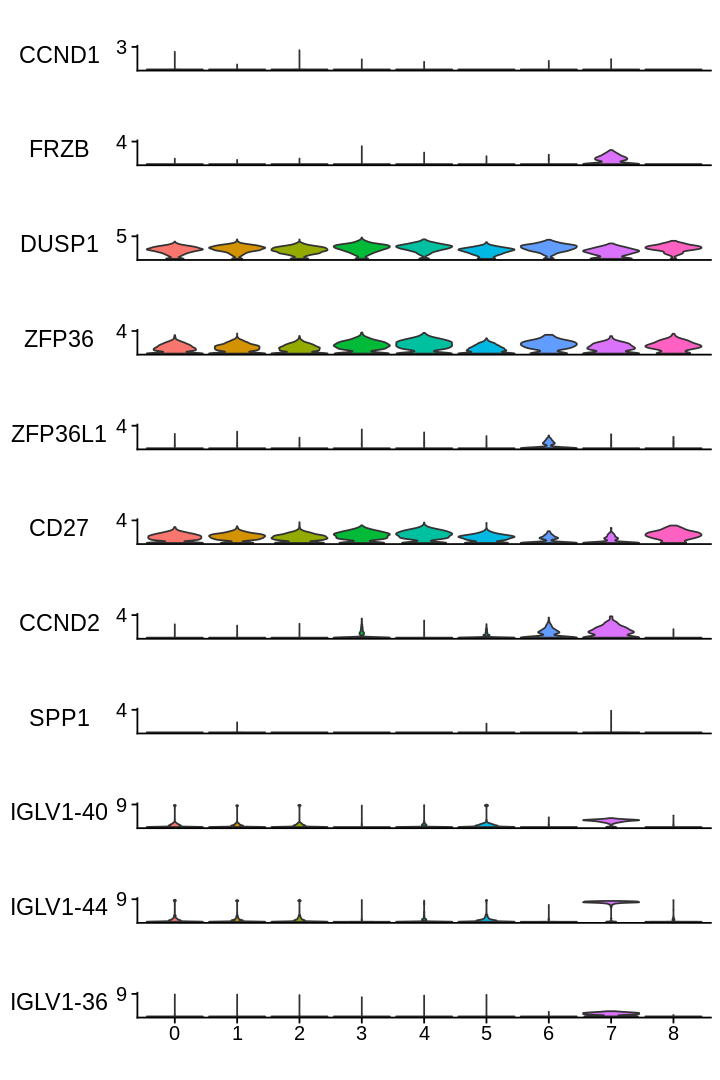

In [94]:
options(repr.plot.height=9,repr.plot.width=6)
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27","CCND2","SPP1","IGLV1-40","IGLV1-44","IGLV1-36")
StackedVlnPlot(obj =plasma, features = features)

In [95]:
save(plasma,file="0419-POEMS14-5.Rda")